# All Mart - High Value Customer Identification

Identificação de clientes mais valiosos de uma empresa e projecção de um programa de fidelidade para os mesmos.

# Planejamento da Solução (IOT)

## Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
2. Conjunto de dados
     - Vendas de um e-commerce online, durante o período de um ano.

## Output - Saída

1. A indicação das pessoas que farão parte do programa de _insiders_
    - Lista: cliente_id | is_insider | 
    

2. Relatório com as respostas das perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa insiders?
    - Quantos clientes farõa parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível aos insiders?
    - Quais as condições para um apessoa ser removida dos insiders?
    - Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV (LifeTime Value)
        - Baixa Recência
        - Alto "Basket Size" (cesta de compra)
        - Baixa probabilidade de Churn
        - Alta Previsão de LTV 
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução

    - Experiência de compra:
        - Alta média de avaliações
    
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo _Insiders_
3. Quais as principais características desses clientes?
    - Idade
    - Localização
    
4. Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Faturamento total do ano
    - Faturamento do grupo _Insiders_
    
5. Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - LTV do grupo _Insiders_
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível aos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
    
7. Quais as condições para um apessoa ser removida dos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo

8. Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Teste de hipóteses
    - Teste A/B bayesiano
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Produtos exclusivos

# 0.0 Imports

In [1]:
# !pip install pandas_profiling

In [2]:
!pip -V

pip 23.1 from /home/leandrotag/.pyenv/versions/3.10.11/envs/allmart/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
# from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import plotly.express as px
import re
from IPython.display import HTML
import matplotlib.font_manager
import matplotlib.cm as cm



# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder

# Models
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors

# Visualização de clusters
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
import umap.umap_ as umap

from scipy.cluster import hierarchy as hc


# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Warnings
import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 15

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    color_pal = sns.color_palette()
    plt.style.use('ggplot')
    sns.set()
jupyter_settings()

## 0.2 CFG

In [5]:
class CFG:
    FOLDS = 5
    seed = 1
    TARGET = ''
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

# 1.0 Data Reading

## 1.1 Data Loading

In [6]:
df1 = pd.read_csv('../data/01_raw/Ecommerce.csv', encoding='unicode_escape')
df1.drop(columns=['Unnamed: 8'], axis=1, inplace=True)
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.2 Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3 Data Dtypes

In [8]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4 Checking NA

In [9]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 2.0 Data Wrangling

In [10]:
df2 = df1.copy()

## 2.1 Rename Columns

In [11]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = cols_new

## 2.2 Replacing NAs

In [12]:
df_missing = df2.loc[df2['customer_id'].isna(), :]
df_not_missing = df2.loc[~df2['customer_id'].isna(), :]

In [13]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


# merge original with reference dataframe
df2 = pd.merge(df2, df_backup, on='invoice_no', how='left')

# coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])

# drop extra columns
df2 = df2.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [14]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [15]:
# missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
# missing_invoice[:10]

In [16]:
# df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :].head()

Não há intersecção entre transações em que o cliente não seja identificado com transações com cliente identificado.

In [17]:
# df_not_missing.customer_id.max()

In [18]:
# df_missing.head(15)

In [19]:
df2.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'Removed data: {1-(df2.shape[0]/df1.shape[0]):.2f}')

Removed data: 0.00


In [20]:
df2.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 2.3 Changing Dtypes

In [21]:
# Invoice Date
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# Customer ID
df2['customer_id'] = df2['customer_id'].astype(int)

In [22]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 2.4 Drop Duplicates

In [23]:
# Create DataFrame Reference

df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 2.5 Descriptive Statistics

### 2.5.1. Numerical Features

In [24]:
num_cols = df2.select_dtypes(include=['number'])
cat_cols = df2.select_dtypes(exclude=['number', 'datetime64[ns]'])

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_cols.apply(np.mean)).T
ct2 = pd.DataFrame(num_cols.apply(np.median)).T


#  Dispersion - Desvio Padrão, minimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_cols.apply(np.std)).T
d2 = pd.DataFrame(num_cols.apply(np.min)).T
d3 = pd.DataFrame(num_cols.apply(np.max)).T
d4 = pd.DataFrame(num_cols.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_cols.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_cols.apply(lambda x: x.kurtosis())).T

# Concat
descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
descriptive

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.60,3.00,218.01,-0.28,120252.45
1,unit_price,-11062.06,38970.00,50032.06,4.62,2.08,96.89,186.26,58848.02
2,customer_id,12346.00,22709.00,10363.00,16678.15,16241.00,2907.57,0.49,-0.79


Investigar:
1. Quantidade negativa: pode significar "devolução"
2. Preço unitário igual a zero: pode ser promoção


### 2.5.1. Categorical Features

#### Invoice No
Problema: detectamos que Invoice_no apresenta letras além de números. Precisamos converter para inteiro.

In [26]:
df_invoices_cat = cat_cols.loc[cat_cols['invoice_no'].apply(lambda x: bool(re.search('[^0-9+]', x))), 'invoice_no']

# o regex acima procura necessariamente por CARACTERES != de numeros (^) sendo 1 ou mais caracteres.

print(f'Número total de transações: {df_invoices_cat.shape[0]}')
print(f'Número total de quantidades negativas: {df2.loc[df2["quantity"] < 0].shape[0]}')

Número total de transações: 9291
Número total de quantidades negativas: 9762


Podemos assumir que quando há uma letra no "invoice_no" significa que esta transação foi retornada ou cancelada. A letra "C" provalmente é um indicativo de _charge back_ ("estorno", em inglês).

#### Stock Code
Não sabemos o que significam essas siglas, por isso iremos removê-las nesse primeiro momento.

In [27]:
# Stock Code

cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()
# O regex acima procura por strings que DEVEM começar com uma letra(^), e DEVEM terminar ($) com uma letra OU MAIS (+)

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description
Iremos também deletar a variável description, por não apresentar informações relevantes neste primeiro momento.

In [28]:
df2['description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

#### Country
Uma das formas de avaliar uma região, é observar o quão representativo cada uma delas é em nosso dataset. Vamos observar a seguir:

In [29]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [30]:
df2['country'].value_counts(normalize=True).reset_index().head(10)

,index,country
0,United Kingdom,0.91
1,Germany,0.02
2,France,0.02
3,EIRE,0.02
4,Spain,0.00
5,Netherlands,0.00
6,Belgium,0.00
7,Switzerland,0.00
8,Portugal,0.00
9,Australia,0.00


Podemos visualizar também a quantidade de clientes únicos por país. Vamos visualizar os 10 países com mais clientes:

In [31]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


Os 10 países com menos clientes:

In [32]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).tail(10)

,country,customer_id
35,United Arab Emirates,2
8,Czech Republic,1
22,Lithuania,1
11,European Community,1
21,Lebanon,1
28,RSA,1
29,Saudi Arabia,1
30,Singapore,1
17,Iceland,1
4,Brazil,1


# 3.0 Feature Filtering

Aqui tomaremos as ações decididas na seção anterior para selecionar da melhor forma as nossas features para análise.

In [33]:
df3 = df2.copy()

In [34]:
###### Numerical Cols ######
df3 = df3.loc[df3['unit_price'] > 0.04, :]


###### Categorical Cols ######
df3 = df3.loc[~df3['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


# Description
df3 = df3.drop(columns='description', axis=1)


# Map
df3 = df3[~df3['country'].isin(['European Community', 'Unspecified'])]


# Bad Users - Atualizado após Análise Univariada
df3 = df3[~df3['customer_id'].isin([16464])]

# Quantity - negative numbers means product returns
df3_returns = df3.loc[df3['quantity'] < 0, :]
df3_purchases = df3.loc[df3['quantity'] > 0, :]


# 4.0 Feature Engineering

- Algumas ideias:
    
    - Moving average: 7d, 14d, 30d
    - Quantidade de compras por mês: antes do dia 15 e depois do 15;
    - Average Financial
    - Basket Size * Price: Quantidade de preços por cesta
    


In [255]:
df4 = df3.copy()

In [256]:
# data referecen
df_ref = df4.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

## 4.1 Gross Revenue
_Receita Bruta._

In [257]:
df3_purchases.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850,15.30
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850,20.34
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850,22.00
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850,20.34
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850,20.34


In [258]:
# Gross Revenue (Faturamento = Quantidade * Preço)
df3_purchases['gross_revenue'] = df3_purchases['quantity'] * df3_purchases['unit_price']

# Monetary
df_monetary = df3_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index().copy()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

## 4.2 Recency
_Quantidade de dias desde a última compra._

In [259]:
# Recency: Dia da última compra
df_recency = df3_purchases.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency']].copy()
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency          91
dtype: int64

## 4.3 Quantity of purchased 
_Quantas compras uma pessoa fez, ex: quantas vezes uma pessoa foi ao mercado e usou uma cesta, sem importar a qtdade de produtos nela._

In [260]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = (df3_purchases[['customer_id', 'invoice_no']].drop_duplicates()
                                                      .groupby('customer_id')
                                                      .count()
                                                      .reset_index()
                                                      .rename(columns={'invoice_no':'qtde_invoices'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'quantity'
                      },
             inplace=True)

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
dtype: int64

## 4.4 Quantity of items purchased
_Quantidade de itens numa compra._

In [261]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = (df3_purchases[['customer_id', 'quantity']].groupby('customer_id').sum()
                                                    .reset_index()
                                                    .rename(columns={'quantity':'qtde_items'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
qtde_items       91
dtype: int64

## 4.4.1 Quantity of products purchased
_Quantidade de produtos (X produtos por item) numa compra._

In [262]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = (df3_purchases[['customer_id', 'stock_code']].groupby('customer_id').count()
                                                    .reset_index()
                                                    .rename(columns={'stock_code':'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

## 4.5 Average Ticket Value
*Gasto médio por compra.*

In [263]:
# Avg Ticket - Ticket Médio
df_avg_ticket = df3_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

## 4.6 Average Recency Days (diff_days)
*Média de intervalo de dias entre compras.*

In [264]:
# Average Recency Days
df_aux46 = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux46['next_customer_id'] = df_aux46['customer_id'].shift() # next customer
df_aux46['previous_date'] = df_aux46['invoice_date'].shift() # next customer

df_aux46['avg_recency_days'] = df_aux46.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id']
                                                                      else np.nan, axis=1)

df_aux46 = df_aux46.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# Average Recency Table
df_avg_recency_days = df_aux46.groupby('customer_id').mean().reset_index()


# Merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
monetary              91
recency               91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

## 4.7 Frequency Purchase
*Taxa de frequência de compras.*

In [265]:
df_aux47 = (df3_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_ = ('invoice_date', 'max'),
                                                                  min_ = ('invoice_date', 'min'),
                                                                  days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) +1) ,
                                                                  buy_ = ('invoice_no', 'count'))).reset_index()

# Frequency
df_aux47['frequency'] = df_aux47[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux47[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
monetary              91
recency               91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

## 4.8 Returns
*Quantos itens foram retornados por cliente e quantas devoluções foram feitas por cliente.*

In [266]:
# Number of retursn
# df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').agg(qtdade_itens_retornados = ('quantity', lambda x: x.sum() * -1))
                                                                                 # num_retornos = ('quantity', 'count')).reset_index()
    
df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtdade_itens_retornados'})
df_returns['qtdade_itens_retornados'] = df_returns['qtdade_itens_retornados'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtdade_itens_retornados'].isna(), 'qtdade_itens_retornados'] = 0
# df_ref.loc[df_ref['num_retornos'].isna(), 'num_retornos'] = 0
df_ref.isna().sum()

customer_id                   0
monetary                     91
recency                      91
qtde_invoices                91
qtde_items                   91
qtde_products                91
avg_ticket                   91
avg_recency_days           2816
frequency                    91
qtdade_itens_retornados       0
dtype: int64

## 4.9 Basket Size - Quantidade de Items por Cesta
- Invoice No: compra
- Stock Code: produto
- Quantity

In [267]:
df_aux49 = (df3_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id') \
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('quantity', 'sum')) \
                                                                          .reset_index())
# calculation
serie_49 = df_aux49['n_products'] / df_aux49['n_purchase']
df_aux49['avg_basket_size'] = serie_49

# merge
df_ref = pd.merge(df_ref, df_aux49[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                   0
monetary                     91
recency                      91
qtde_invoices                91
qtde_items                   91
qtde_products                91
avg_ticket                   91
avg_recency_days           2816
frequency                    91
qtdade_itens_retornados       0
avg_basket_size              91
dtype: int64

## 4.10 Unique Basket Size - Quantidade de produtos distintos por compra

In [268]:
df_aux410 = (df3_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id') \
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('stock_code', 'nunique')) \
                                                                          .reset_index())
# calculation
serie_410 = df_aux410['n_products'] / df_aux410['n_purchase']
df_aux410['avg_unique_basket_size'] = serie_410

# merge
df_ref = pd.merge(df_ref, df_aux410[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                   0
monetary                     91
recency                      91
qtde_invoices                91
qtde_items                   91
qtde_products                91
avg_ticket                   91
avg_recency_days           2816
frequency                    91
qtdade_itens_retornados       0
avg_basket_size              91
avg_unique_basket_size       91
dtype: int64

In [269]:
# df_ref.drop(columns='invoice_date', axis=1, inplace=True)
df_ref.head()

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00,50.97,0.62
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00,154.44,11.67
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00,335.20,7.60
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,4.80
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33


In [270]:
# # Gross Revenue (Faturamento = Quantidade * Preço)
# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # Monetary: Faturamento
# df_monetary = df3.groupby('customer_id')['gross_revenue'].sum().reset_index()
# df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')

# # Recency: Dia da última compra
# df_recency = df3.groupby('customer_id')['invoice_date'].max().reset_index()
# df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')

# # Frequency - Contagem do número de compras feitas pelo cliente
# df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
# df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

# # Avg Ticket - Ticket Médio
# df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
# df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [51]:
# df_ref.drop('invoice_date', inplace=True, axis=1)
# df_ref.head()

# 5.0 EDA (Exploratory Data Analysis)

In [271]:
df5 = df_ref.dropna()
df5.isna().sum()

customer_id                0
monetary                   0
recency                    0
qtde_invoices              0
qtde_items                 0
qtde_products              0
avg_ticket                 0
avg_recency_days           0
frequency                  0
qtdade_itens_retornados    0
avg_basket_size            0
avg_unique_basket_size     0
dtype: int64

## 5.1. Univariate Analysis

**Notas Importantes na Análise Univariada**
1. Clusters Coesos - Separados
1. Métricas Importantes:
    1. Min, Máximo, Range (Dispersão)
    1. Média e Mediana
    1. Desvio Padrão e Variância
    1. Coeficiente de Variação (Desvio Padrão/Média)
        1. Maior -> dados concentrados, próximos.
        1. Menor -> dados dispersos, distantes.
    1. Distribuição

**Investigar e/ou Remover**

1. Monetary - ok
2. Recency - ok
3. Qtdade Invoice - ok
4. Qtdade Items - red flag (valor máximo diferente do 2º valor máximo)
5. Qtdade Products - ok
6. Avg Ticket - red flags (correlation, skewed)

### 5.1.1 Monetary

In [53]:
df5.sort_values('monetary', ascending=False).head()

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.00,72.00,196844.00,2060.00,135.50,7.84,0.20,288.00,2733.94,9.71
492,18102,259657.30,0.00,60.00,64124.00,431.00,602.45,14.68,0.16,0.00,1068.73,2.50
433,17450,194550.79,8.00,46.00,69993.00,337.00,577.30,12.82,0.13,952.00,1521.59,2.70
3338,16446,168472.50,0.00,2.00,80997.00,3.00,56157.50,205.00,0.01,80995.00,40498.50,1.50
66,14911,140438.72,1.00,199.00,79963.00,5670.00,24.77,2.60,0.53,3332.00,401.82,8.97


In [54]:
df5[df5['customer_id'] == 14646]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.00,72.00,196844.00,2060.00,135.50,7.84,0.20,288.00,2733.94,9.71


### 5.1.2 Qtdade Items

In [55]:
df5[df5['qtde_items'] == 196844]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.00,72.00,196844.00,2060.00,135.50,7.84,0.20,288.00,2733.94,9.71


In [56]:
df4[df4['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


### 5.1.3 Avg Ticket

In [57]:
df5[df5['avg_ticket'] == 56157.5]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
3338,16446,168472.50,0.00,2.00,80997.00,3.00,56157.50,205.00,0.01,80995.00,40498.50,1.50


In [58]:
df4[df4['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


Podemos observar um comportamento estranho deste cliente: realizou uma compra de alta quantidade, e logo em seguida fez o retorno de 100% da mesma. Iremos excluí-lo em nossa seção 3 do Notebook.

### 5.1.4 Frequency

In [59]:
df5[df5['frequency'] == 17]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62


In [60]:
df4[df4['customer_id'] == 17850].sort_values('quantity', ascending=False).head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2016-11-30,2.75,United Kingdom,17850
4162,536750,71053,12,2016-11-30,3.39,United Kingdom,17850
3808,536685,85123A,12,2016-11-30,2.55,United Kingdom,17850
4526,536790,85123A,12,2016-11-30,2.95,United Kingdom,17850
4527,536790,71053,12,2016-11-30,3.39,United Kingdom,17850
3809,536685,71053,12,2016-11-30,3.39,United Kingdom,17850
4531,536790,37370,12,2016-11-30,1.06,United Kingdom,17850
4532,536790,21071,12,2016-11-30,1.06,United Kingdom,17850
4533,536790,21068,12,2016-11-30,1.06,United Kingdom,17850
290,536396,82494L,12,2016-11-29,2.55,United Kingdom,17850


### 5.1.4 Average Basket Size


In [61]:
df5[df5['avg_basket_size'] == 40498.5]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
3338,16446,168472.50,0.00,2.00,80997.00,3.00,56157.50,205.00,0.01,80995.00,40498.50,1.50


Mais uma vez, uma peculiaridade apresentada pelo mesmo cliente. Removendo o mesmo do nosso dataset, podemos esperar um grande aprimoramento.

In [62]:
# profile = ProfileReport(df5)
# profile.to_file("output_c07.html")

## 5.2. Bivariate Analysis

In [63]:
df5.head()

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,154.44,11.67
2,12583,6705.38,2.00,15.00,5028.00,232.00,28.90,23.19,0.04,50.00,335.20,7.60
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,4.80
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33


In [64]:
drop_cols = ['customer_id']
df52 = df5.drop(drop_cols, axis=1)

CPU times: user 1min 13s, sys: 628 ms, total: 1min 14s
Wall time: 1min 13s


<Figure size 1500x800 with 0 Axes>

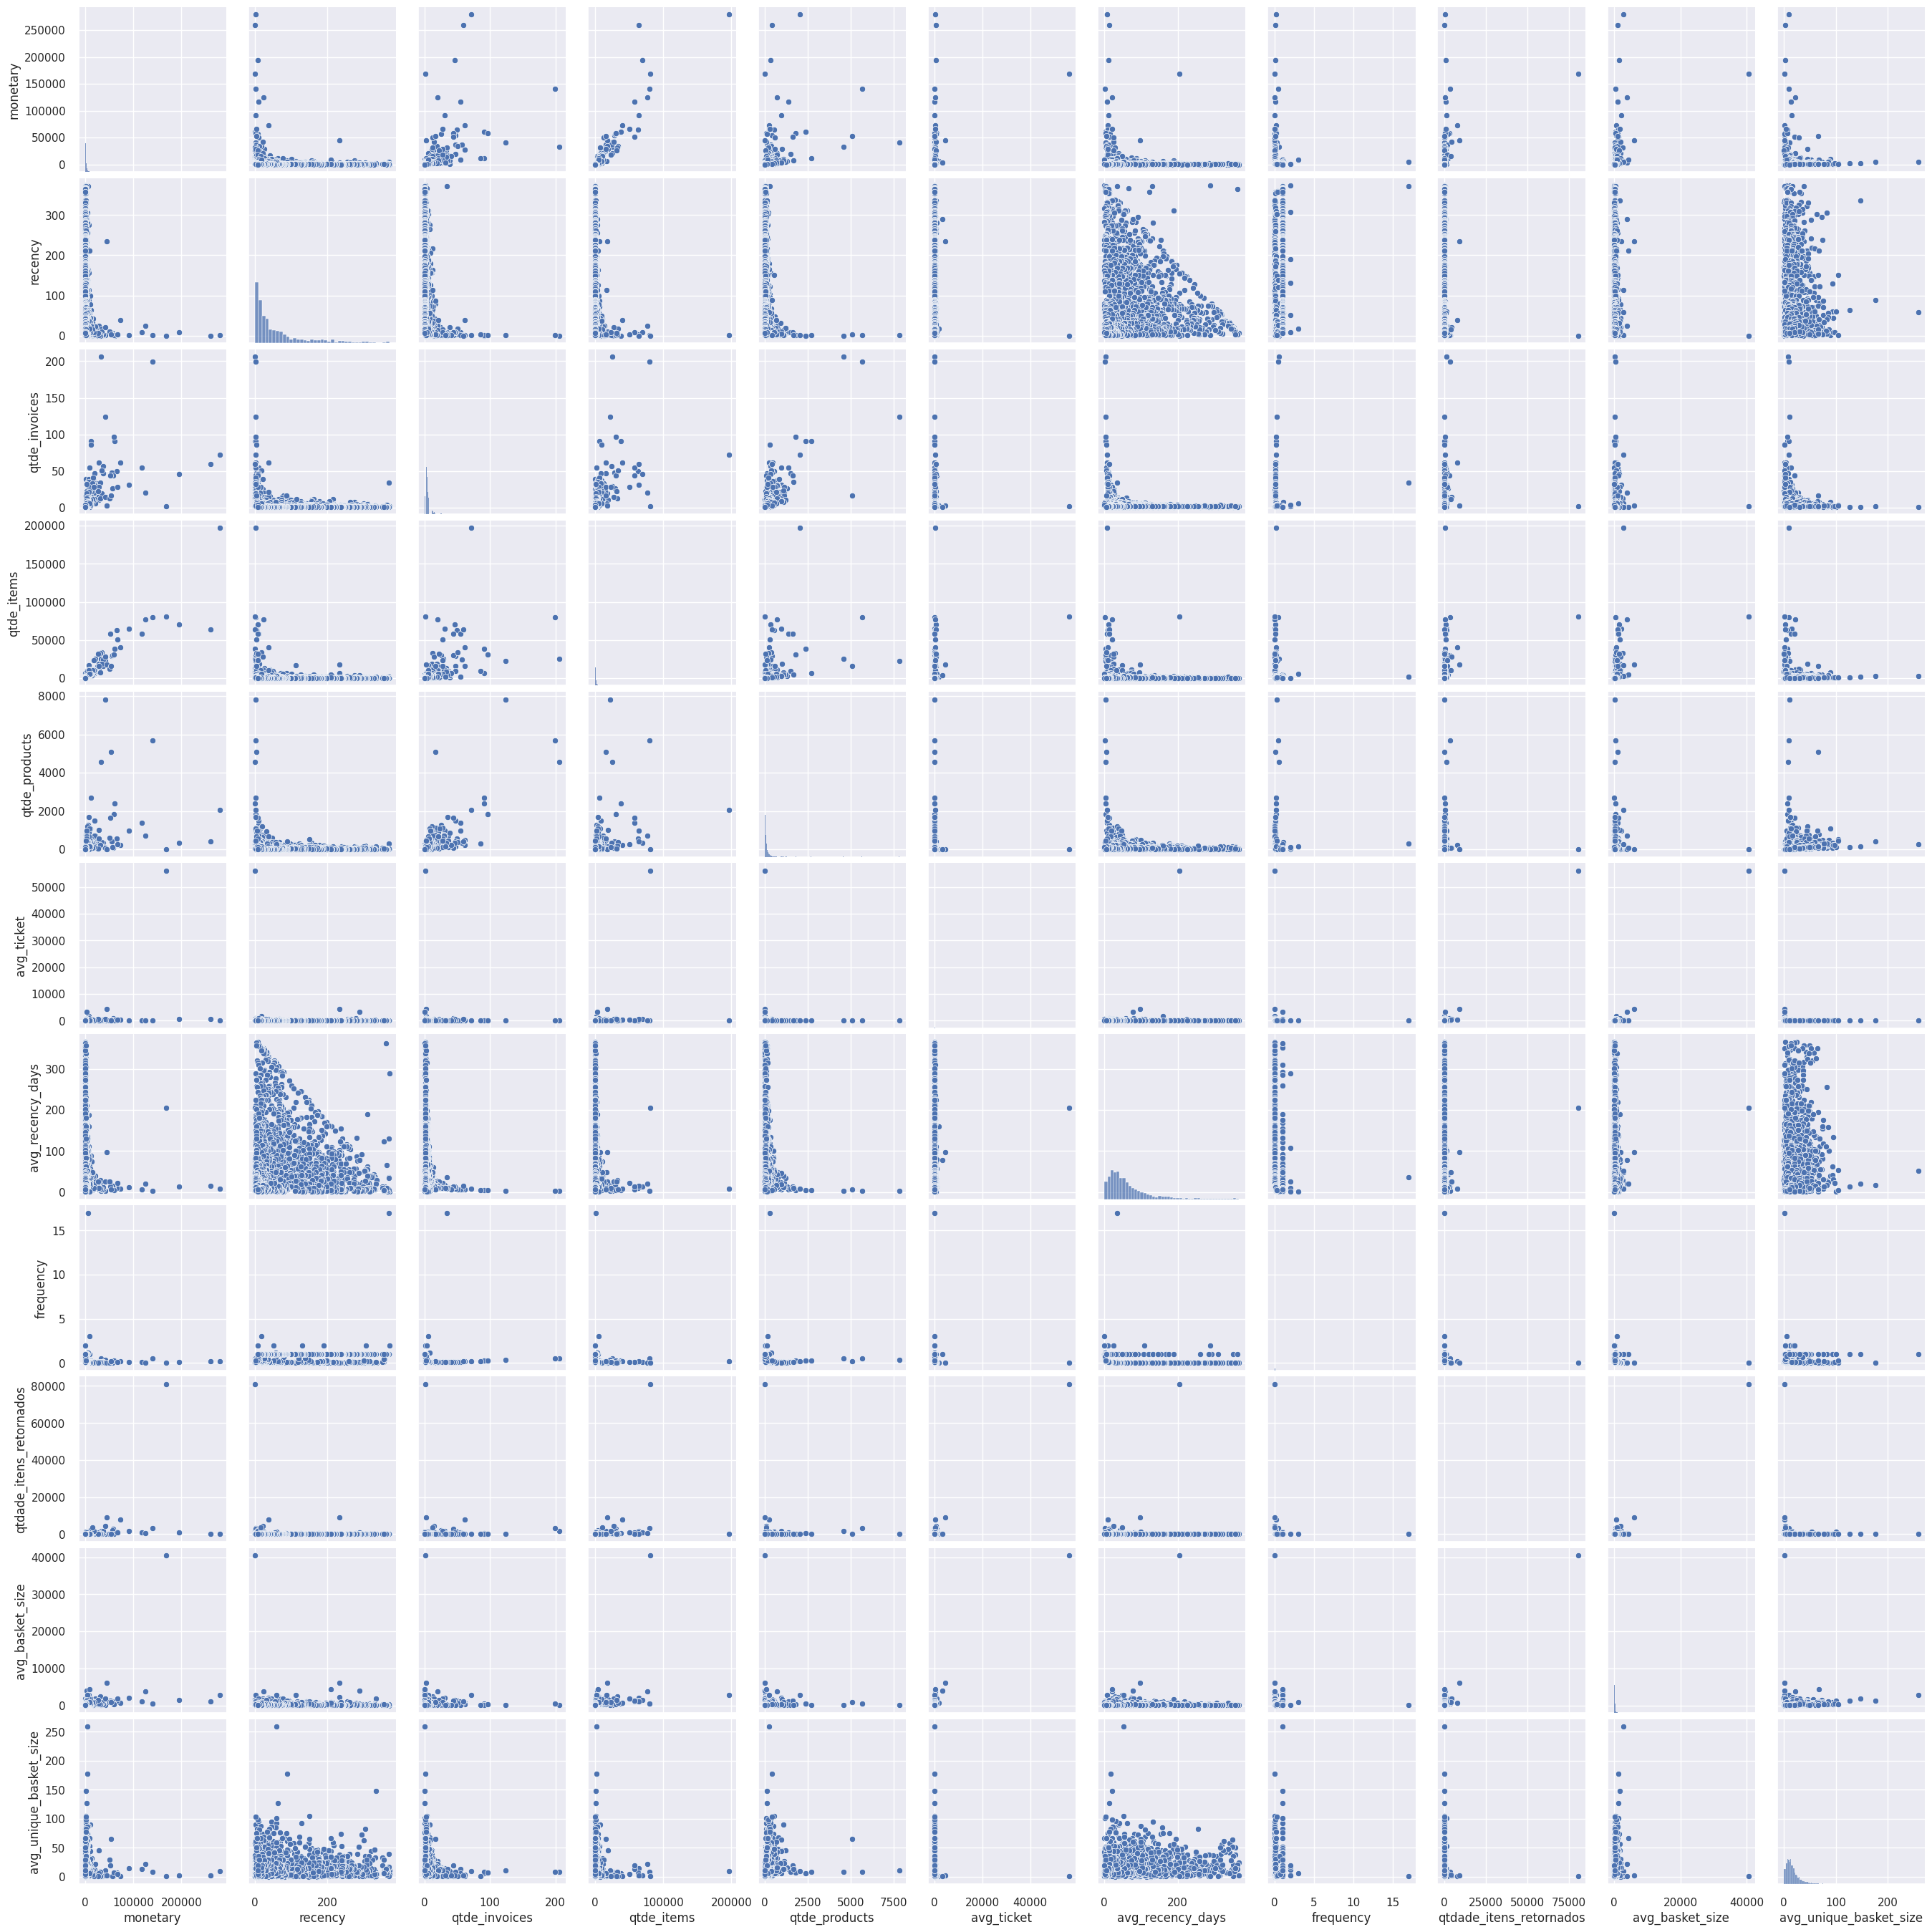

In [64]:
%%time

plt.figure(figsize=(15, 8))
sns.pairplot(df52);

A partir do `pairplot`, devemos observar as features com menos variabilidade, pois estas não irão contribuir de forma considerável na construção dos nossos clusters.
Ex:
- 'frequency' e 'avg_ticket' (pouca variabilidade);
- 'qtdade_invoices', 'qtdade_items' e 'qtdade_products' com distribuições bastante parecidas (Alta Correlação, ou seja, irão explicar a mesma parte),

## 5.3. Estudo do Espaço

In [65]:
df53 = df5.drop(columns=['customer_id'], axis=1).copy()

In [66]:
df53.head()

,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
0,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62
1,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,154.44,11.67
2,6705.38,2.00,15.00,5028.00,232.00,28.90,23.19,0.04,50.00,335.20,7.60
3,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,4.80
4,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33


In [67]:
minmax = MinMaxScaler()

df53['monetary']               = minmax.fit_transform(df53[['monetary']])
df53['recency']                = minmax.fit_transform(df53[['recency']])
df53['qtde_invoices']          = minmax.fit_transform(df53[['qtde_invoices']])
df53['qtde_items']             = minmax.fit_transform(df53[['qtde_items']])
df53['qtde_products']          = minmax.fit_transform(df53[['qtde_products']])
df53['avg_ticket']             = minmax.fit_transform(df53[['avg_ticket']])
df53['avg_recency_days']              = minmax.fit_transform(df53[['avg_recency_days']])
df53['frequency']              = minmax.fit_transform(df53[['frequency']])
df53['qtdade_itens_retornados']           = minmax.fit_transform(df53[['qtdade_itens_retornados']])
df53['avg_basket_size']        = minmax.fit_transform(df53[['avg_basket_size']])
df53['avg_unique_basket_size'] = minmax.fit_transform(df53[['avg_unique_basket_size']])

X = df53.copy()

In [68]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [69]:
X.head()

,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size
0,0.01929,0.99732,0.16098,0.00880,0.03777,0.00028,0.09452,1.00000,0.00049,0.00123,0.00161
1,0.01156,0.15013,0.03902,0.00706,0.02169,0.00030,0.07192,0.00134,0.00043,0.00379,0.04431
2,0.02400,0.00536,0.06829,0.02554,0.02948,0.00048,0.06079,0.00205,0.00062,0.00825,0.02859
3,0.00337,0.25469,0.01951,0.00223,0.00345,0.00056,0.25114,0.00073,0.00000,0.00214,0.01777
4,0.00312,0.89276,0.00976,0.00040,0.00026,0.00516,0.02082,0.00398,0.00027,0.00063,0.00052


In [70]:
n_dim = X.shape[1]

In [71]:
print(f'Teremos um espaço de {X.shape[1]} dimensões.')

Teremos um espaço de 11 dimensões.


### 5.3.1 PCA

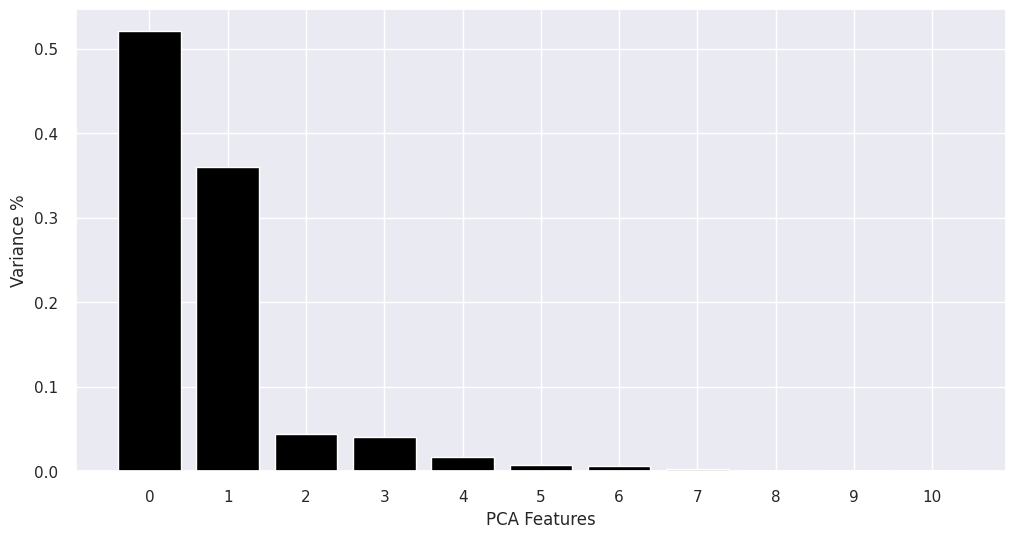

In [72]:
# Create a PCA instance
pca = PCA(n_components=n_dim)
principal_components = pca.fit_transform(X)

# Plot explained Variances
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA Features')
plt.ylabel('Variance %')
plt.xticks(features)

# Save Components to a DataFrame
df_pca = pd.DataFrame(principal_components)

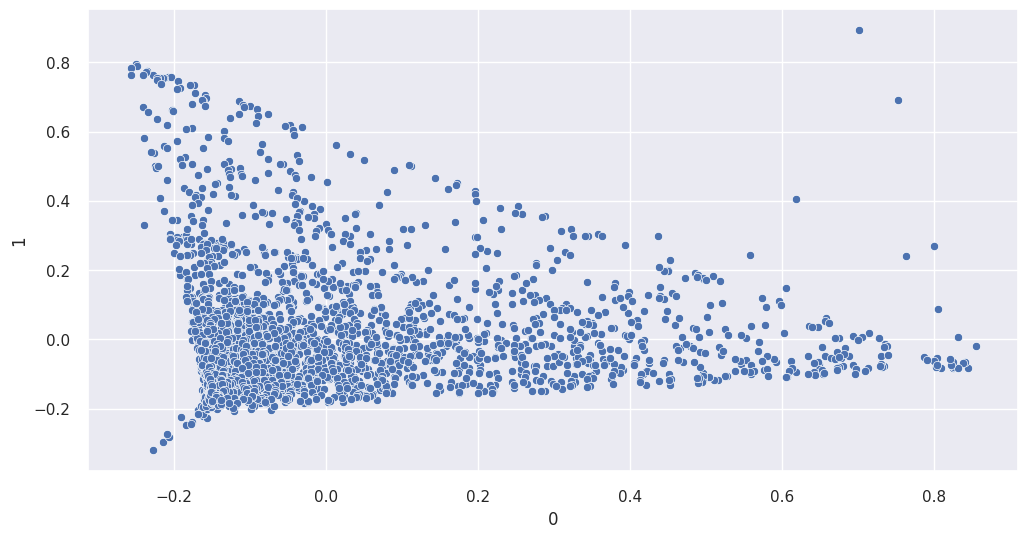

In [73]:
sns.scatterplot(x=0, y=1, data=df_pca);

Podemos observar que a construção de clusters para a visualização acima é bem dificultada, pela alta aproximação dos pontos gerada pela técnica de PCA.

### 5.3.2 UMAP

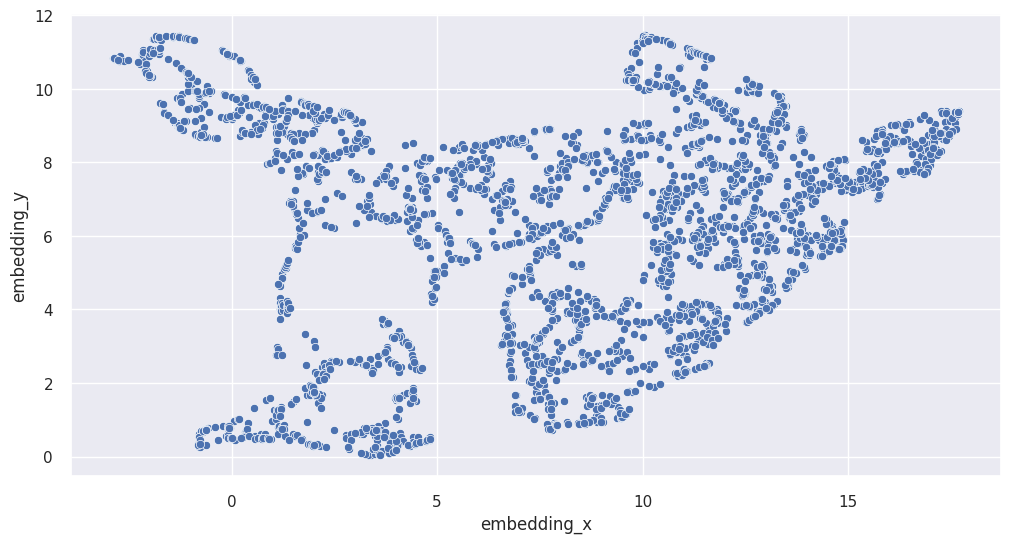

In [90]:
reducer = umap.UMAP(n_neighbors=10, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_umap);

Perceba que o UMAP também não apresenta um embedding apropriado para a criação de clusters.

### 5.3.3 t-SNE

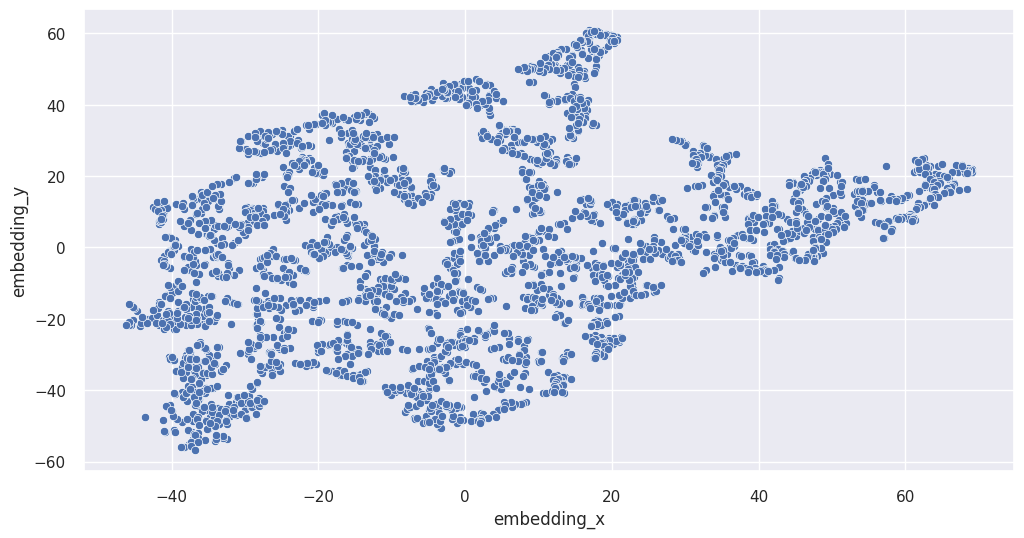

In [75]:
tsne = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = tsne.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tsne);

O mesmo ocorre com o t-SNE.

### 5.3.4 Tree-Based Embeddings

Precisamos definir como iremos construir esse espaço. Iremos construí-lo com uma variável que obtenhamos uma maior divisão dos clientes. Do ponto de vista de negócio, desejamos uma variável que nos permita encontrar os clientes mais valiosos. Entendemos que esta variável seria a "monetary", já que esta mede o gasto total dos clientes.

Portanto, iremos definí-la como uma variável resposta, treinar um algoritmo de árvore com todas as outras features para realizarmos a previsão desta variável e plotar um espaço de acordo com as folhas geradas pelas árvores.


In [289]:
# Definição da variável
X_tree = df5.drop(columns=['customer_id', 'monetary'], axis=1)
y = df5['monetary']

# Definição do Modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treino do Modelo
rf_model.fit(X_tree, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X_tree))

# DataFrame Leaf
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3169,2724,3389,3076,2271,3304,3254,3136,3166,3013,3165,2881,3078,3169,2841,3198,3017,3190,3109,3252,2916,2670,2905,3292,3314,3125,3024,3159,3101,3049,3067,3389,3362,2976,2955,3031,3412,3146,2948,3077,3352,3216,3246,3134,3180,3142,3137,3335,3187,3134,3106,3210,3103,3393,3165,3203,3169,3321,3249,3331,3386,2938,3331,3248,2950,3120,3229,3275,2719,3266,3297,2980,3302,3272,3119,3170,2965,3102,3213,3153,3130,3324,3349,3068,3298,3172,3292,3386,3138,3226,3167,3179,3205,3055,2855,3112,3200,3365,3351,3291
1,2938,2922,3022,3057,2738,2980,2900,2781,3089,2947,3109,2851,3063,3093,2784,3115,2836,3057,3071,2418,2862,3090,2861,2824,2959,3126,2837,2792,3021,3025,2942,2985,2960,2952,2914,2981,2969,2757,2962,2907,2640,2795,2985,3114,3028,3073,2933,2920,3152,3089,3171,3127,3068,2969,2950,2929,3131,3011,2789,2947,2982,2921,2877,2865,2930,2498,2917,2951,2712,2840,3234,2691,2926,2782,3073,2814,2906,3067,3151,2544,3043,2900,2963,2774,2911,3134,2939,3002,3106,2891,2510,2889,2884,2985,3135,3056,2870,2909,2979,2749
2,3628,3592,3586,3579,3572,3661,3632,3540,3669,3616,3650,3580,3545,3652,3571,3566,3580,3640,3620,3475,3519,3631,3602,3520,3559,3589,3524,3605,3589,3716,3438,3671,3595,3632,3577,3617,3541,3509,3594,3484,3654,3397,3608,3615,3532,3578,3540,3645,3643,3617,3631,3502,3569,3613,3665,3629,3607,3679,3535,3607,3613,3593,3562,3687,3474,3627,3646,3568,3551,3610,3583,3603,3576,3511,3541,3562,3574,3564,3535,3487,3549,3442,3470,3604,3533,3599,3579,3692,3593,3563,3597,3473,3563,3552,3600,3559,3523,3614,3564,3647
3,1240,1427,1564,1925,1884,2234,2111,1768,1628,1785,2062,1283,1327,1613,1526,1826,1882,1565,1425,1425,1824,1267,1302,1526,2244,1995,1621,1810,1657,1245,1837,1535,1552,1568,1333,1590,2189,2192,1666,1561,1965,1435,1454,1814,1250,1672,1581,1444,1281,1666,1830,1135,1328,2199,1582,2023,2179,1909,928,2112,1599,2052,1914,1847,1470,1466,1050,1719,1555,1689,1776,1913,1545,2161,1377,2084,1514,1519,1979,1470,1438,1381,1469,1522,1412,1434,1283,1542,1909,1538,1776,1329,2062,1892,1969,2269,1515,2066,2035,2113
4,204,727,571,598,148,721,223,573,181,191,596,337,671,458,155,605,566,419,869,408,684,695,421,196,632,207,388,574,159,734,704,197,193,324,233,731,599,203,611,597,720,211,177,592,725,572,297,657,704,604,580,181,745,387,543,542,727,656,683,594,229,731,523,202,664,678,477,185,462,611,577,189,348,629,707,193,232,183,112,226,214,704,745,203,587,169,299,976,688,801,345,219,697,558,196,158,190,715,707,194


In [290]:
X_tree.shape, df_leaf.shape

((2968, 10), (2968, 100))

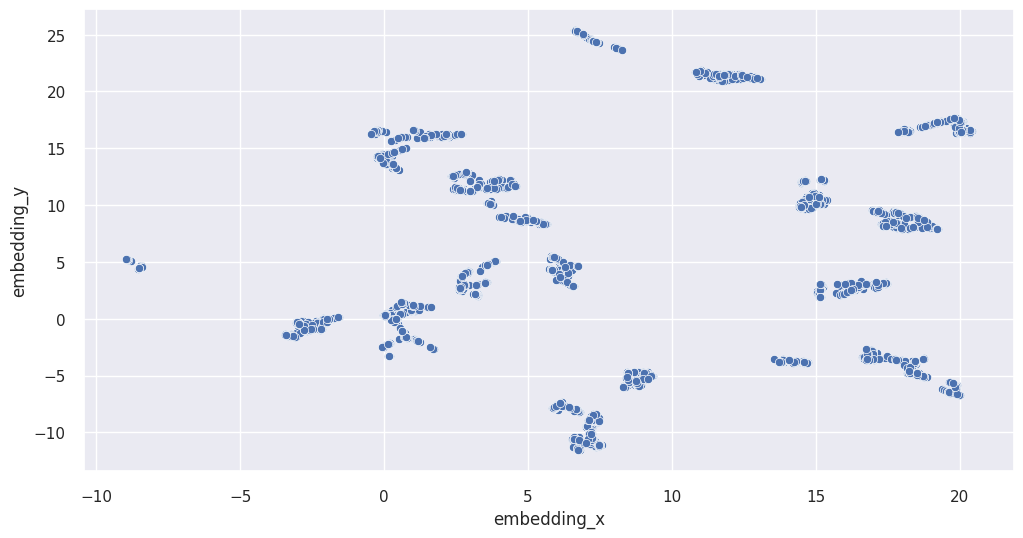

In [291]:
# Dimensionalidade Reduzida
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tree);

Ao utilizarmos esta téncnica, perdemos um pouco de explicabilidade (por conta da redução de dimensionalidade). Porém, ela ainda é extremamente valiosa, pois mostra como o comportamento de uma feature pode influenciar no espaço de criação de clusters. 

# 6.0 Data Preparation & Feature Selection

Vamos aplicar a preparação dos nossos dados, para que não haja interferência na formação de espaços para a posterior criação dos cluters. Lembrando que, na hora da avaliação dos _Clientes Insiders_, teremos que realizar a transformação inversa para ter a noção correta dos valores de negócio. O pré-processamento pode ser feito das seguintes maneiras:

1. Redimensionamento (_Rescaling_): Não necessariamente precisa de que os dados tenham uma Distribuição Normal.
1. Padronização (_Standardization_): Premissa de que os dados vieram de uma Distribuição Normal.

Podemos estender a regra acima para quando houver a presença de *outliers* em nosso conjunto de dados:

1. Distribuição Normal E NÃO possui _Outlier_: **Standard Scaler** - Média e Desvio Padrão;
1. Distribuição Normal E possui _Outlier_: **Robust Scaler** - Quartis;
1. Não-Distribuição Normal: **MinMax Scaler**.

**Testes de Normalidade**
- QQ Plot (Quantile Quantile Plot): Quantile Teorica x Quantile Real
- KS Test (Kolmogorov-Smirnov Test): 
    - Se p-valor >= 0.5 --> Distribuição Normal.
    - se p-valor < 0.5 --> Não-Distribuição Normal
    
    

**Detecção de Outliers**
- Box Plot: pontos são identificados como outliers;
- IQR (Amplitude Interquartil):
    - Lower Bound: Q1 - 1.5*IQR 
    - Upper Bound: Q3 + 1.5*IQR
- Z-Score: outliers para valores acima de 3 e abaixo de -3.

In [292]:
# df6 = df5.copy()
df6 = df_tree.copy()

In [281]:
# Standard Scaler
ss = StandardScaler()
mm = MinMaxScaler()
rs = RobustScaler()

df6['monetary']                  = mm.fit_transform(df6[['monetary']])
df6['recency']                   = mm.fit_transform(df6[['recency']])
df6['qtde_invoices']             = mm.fit_transform(df6[['qtde_invoices']]   )
df6['qtde_items']                = mm.fit_transform(df6[['qtde_items']]   )
df6['qtde_products']             = mm.fit_transform(df6[['qtde_products']]   )
df6['avg_ticket']                = mm.fit_transform(df6[['avg_ticket']]   )
df6['avg_recency_days']          = mm.fit_transform(df6[['avg_recency_days']]   )
df6['frequency']                 = mm.fit_transform(df6[['frequency']] )
df6['qtdade_itens_retornados']   = mm.fit_transform(df6[['qtdade_itens_retornados']])
df6['avg_basket_size']           = mm.fit_transform(df6[['avg_basket_size']])
df6['avg_unique_basket_size']    = mm.fit_transform(df6[['avg_unique_basket_size']])

Acabamos por utilizar o MinMaxScaler em todas as nossas features, após uma avaliação de suas distribuições.

## 6.1 Feature Selection

In [282]:
cols_selected = ['customer_id', 'monetary', 'recency', 'frequency', 'qtde_products', 'qtdade_itens_retornados']

In [283]:
df6_filtered = df6[cols_selected].copy()

# 7.0 Hyperparameter Fine-tuning

In [294]:
# X = df6.drop(columns=['customer_id'])
# X = df6_filtered.drop(columns=['customer_id'])
X = df6.copy()

In [295]:
X.head()

,embedding_x,embedding_y
0,14.62,12.16
1,17.32,8.40
2,8.21,23.73
3,1.74,-2.63
4,-0.46,16.31


In [296]:
# clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange(2, 26, 1)

## 7.1. K-Means

In [297]:
kmeans_list = []
for k in clusters:
    
    # Model Definition
    kmeans_model = KMeans(n_clusters=k, random_state=42)

    # Model Training
    kmeans_model.fit(X)

    # Model Prediction
    kmeans_labels = kmeans_model.predict(X)

    # Model Performance
    kmeans_sil = silhouette_score(X, kmeans_labels, metric='euclidean')
    kmeans_list.append(kmeans_sil)
    print(f"O valor de silhueta para {len(np.unique(kmeans_labels))} {type(kmeans_model).__name__} clusters  é de: {kmeans_sil:.3f}")

O valor de silhueta para 2 KMeans clusters  é de: 0.419
O valor de silhueta para 3 KMeans clusters  é de: 0.475
O valor de silhueta para 4 KMeans clusters  é de: 0.494
O valor de silhueta para 5 KMeans clusters  é de: 0.532
O valor de silhueta para 6 KMeans clusters  é de: 0.591
O valor de silhueta para 7 KMeans clusters  é de: 0.600
O valor de silhueta para 8 KMeans clusters  é de: 0.610
O valor de silhueta para 9 KMeans clusters  é de: 0.647
O valor de silhueta para 10 KMeans clusters  é de: 0.648
O valor de silhueta para 11 KMeans clusters  é de: 0.665
O valor de silhueta para 12 KMeans clusters  é de: 0.676
O valor de silhueta para 13 KMeans clusters  é de: 0.674
O valor de silhueta para 14 KMeans clusters  é de: 0.685
O valor de silhueta para 15 KMeans clusters  é de: 0.684
O valor de silhueta para 16 KMeans clusters  é de: 0.676
O valor de silhueta para 17 KMeans clusters  é de: 0.671
O valor de silhueta para 18 KMeans clusters  é de: 0.688
O valor de silhueta para 19 KMeans clus

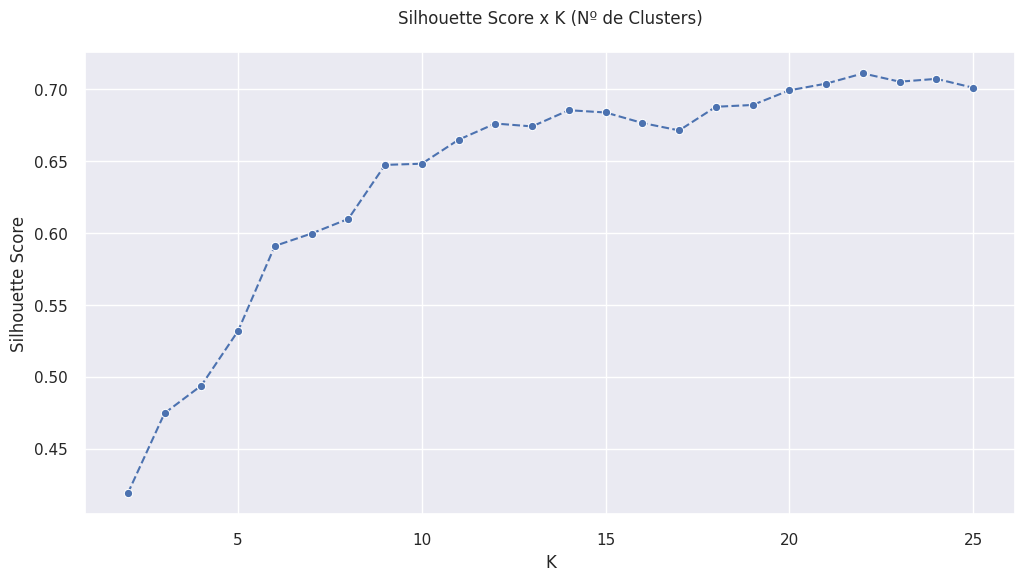

In [298]:
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K (Nº de Clusters)\n')
sns.lineplot(x=clusters, y=kmeans_list, linestyle='--', marker='o', color='b');

## 7.2. GMM (Gaussian Mixture Models)

In [181]:
gmm_list=[]
for k in clusters:
    # Model Defition
    gmm = GaussianMixture(n_components=k)

    # Model Training
    gmm.fit(X)

    # Model Prediction
    gmm_labels = gmm.predict(X)

    # Model Performance
    gmm_sil = silhouette_score(X, gmm_labels, metric='euclidean')
    gmm_list.append(gmm_sil)
    print(f"O valor de silhueta para {len(np.unique(gmm_labels))} clusters de {type(gmm).__name__} é de: {gmm_sil:.3f}")

O valor de silhueta para 2 clusters de GaussianMixture é de: -0.047
O valor de silhueta para 3 clusters de GaussianMixture é de: 0.129
O valor de silhueta para 4 clusters de GaussianMixture é de: -0.010
O valor de silhueta para 5 clusters de GaussianMixture é de: -0.098
O valor de silhueta para 6 clusters de GaussianMixture é de: -0.164
O valor de silhueta para 7 clusters de GaussianMixture é de: 0.051


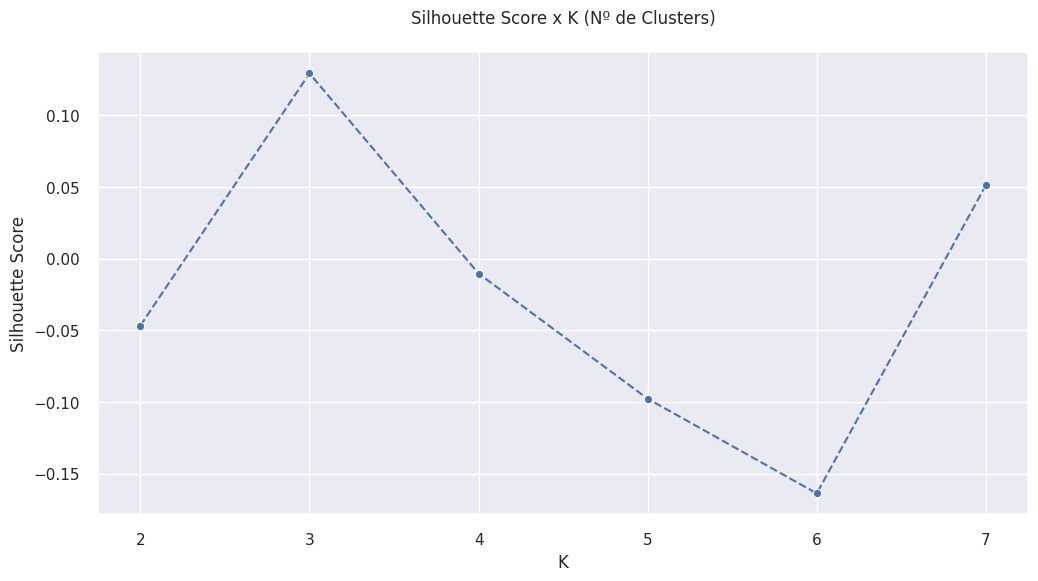

In [182]:
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K (Nº de Clusters)\n')
sns.lineplot(x=clusters, y=gmm_list, linestyle='--', marker='o', color='b');

## 7.3. Hierarchical Clustering

In [183]:
# Model Definition & Training
hc_model = hc.linkage(X, method='ward')

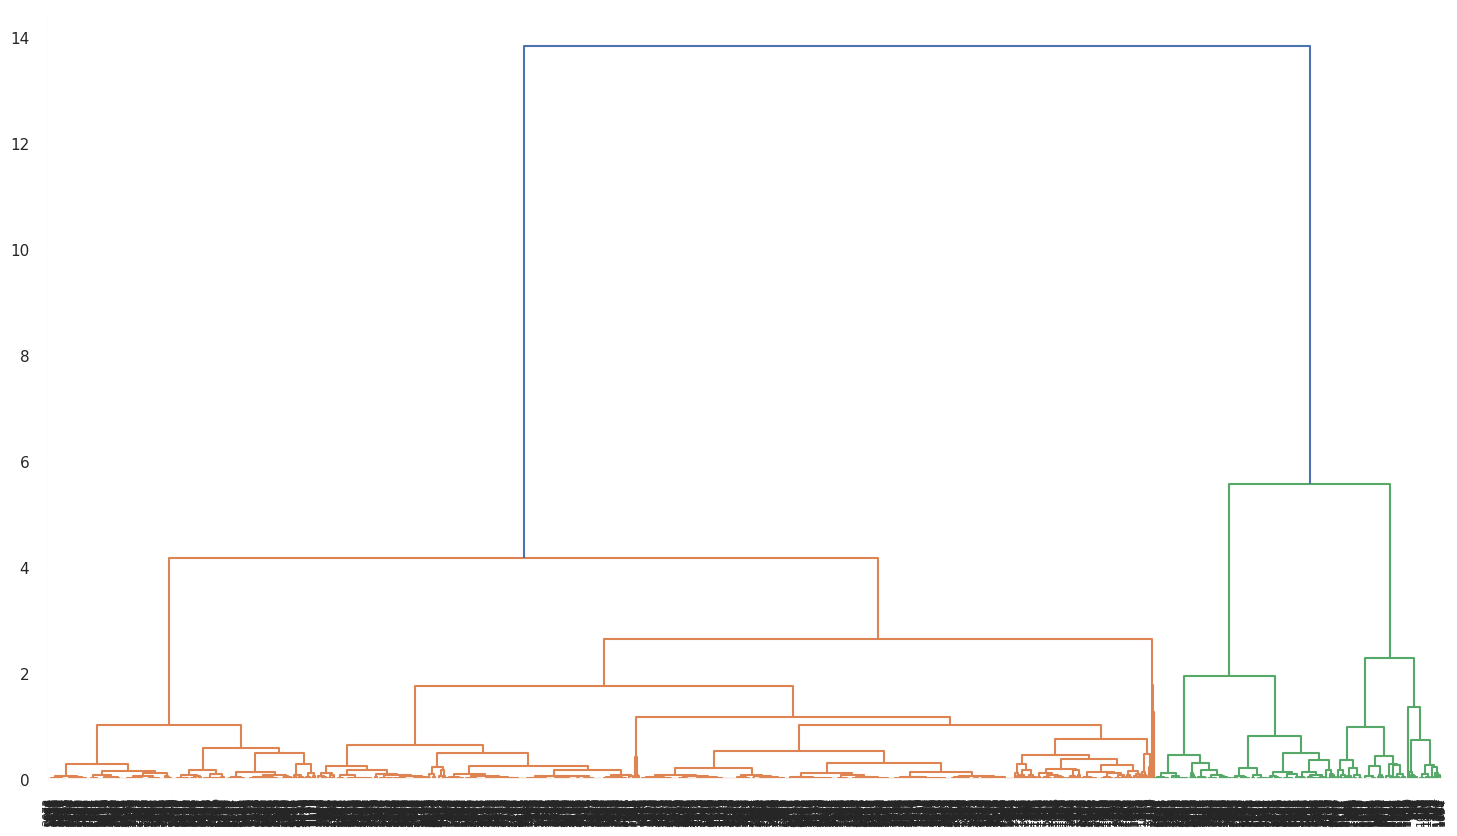

CPU times: user 26 s, sys: 308 ms, total: 26.3 s
Wall time: 26 s


In [184]:
%%time

plt.figure(figsize=(18, 10))
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)
plt.show()

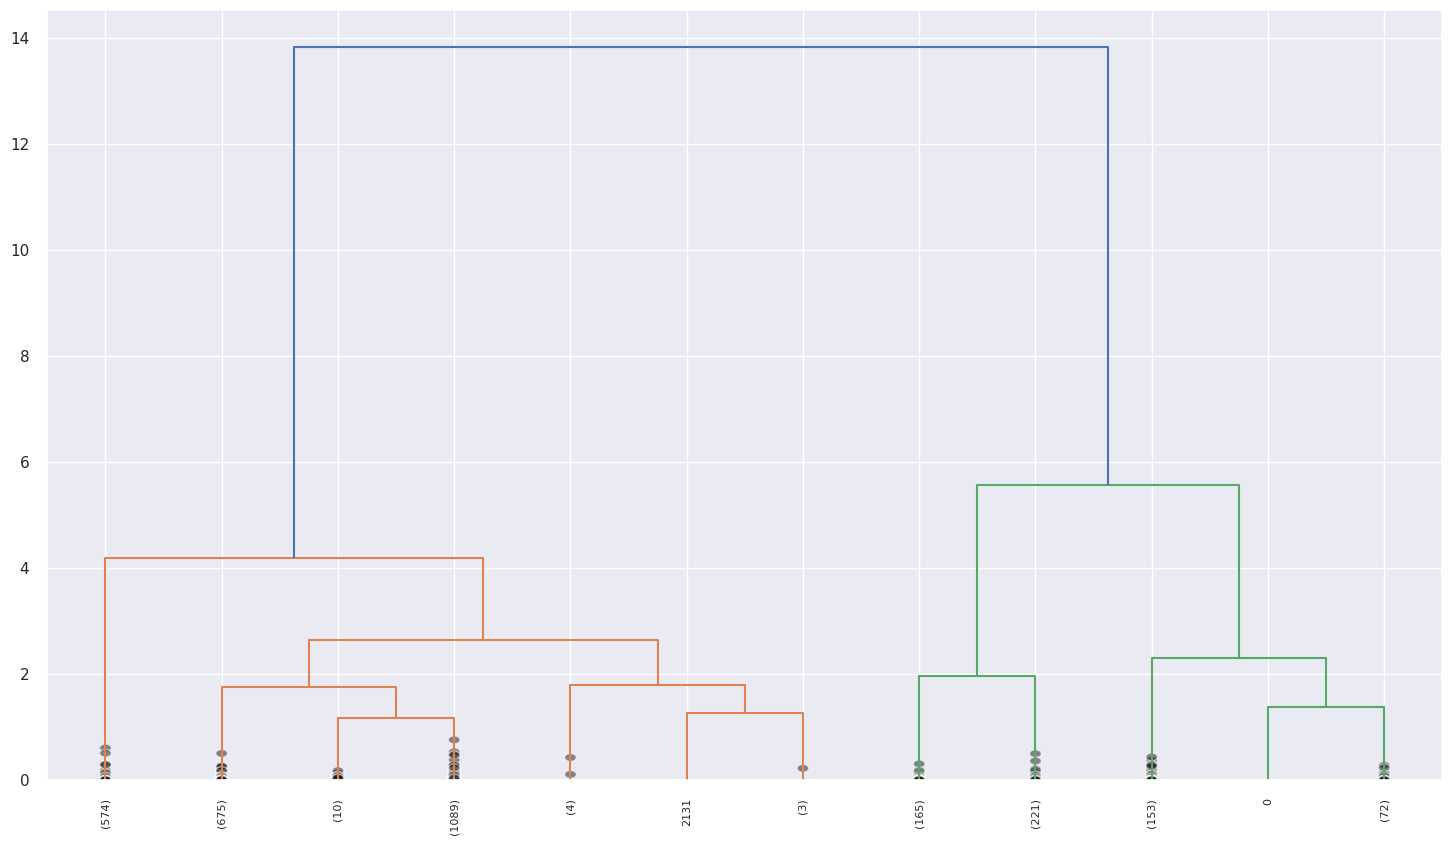

CPU times: user 1.31 s, sys: 199 ms, total: 1.51 s
Wall time: 1.24 s


In [185]:
%%time

plt.figure(figsize=(18, 10))
hc.dendrogram(
              hc_model,
              truncate_mode='lastp',
              p=12,
              leaf_rotation=90,
              leaf_font_size=8,
             show_contracted=True)
plt.show()

### 7.3.1 HC Silhouette Score

In [186]:
k = 2
hc_list=[]
for k in clusters:
    # hc_model = hc.linkage(X, method='ward')

    # Model Predict
    hc_labels = hc.fcluster(hc_model, 
                            k,
                            criterion='maxclust')

    # Metric
    hc_sil = silhouette_score(X, hc_labels, metric='euclidean')
    hc_list.append(hc_sil)
    print(f"O valor de silhueta para {len(np.unique(hc_labels))} {type(hc_model).__name__} clusters  é de: {hc_sil:.3f}")

O valor de silhueta para 2 ndarray clusters  é de: 0.710
O valor de silhueta para 3 ndarray clusters  é de: 0.649
O valor de silhueta para 4 ndarray clusters  é de: 0.541
O valor de silhueta para 5 ndarray clusters  é de: 0.555
O valor de silhueta para 6 ndarray clusters  é de: 0.548
O valor de silhueta para 7 ndarray clusters  é de: 0.544


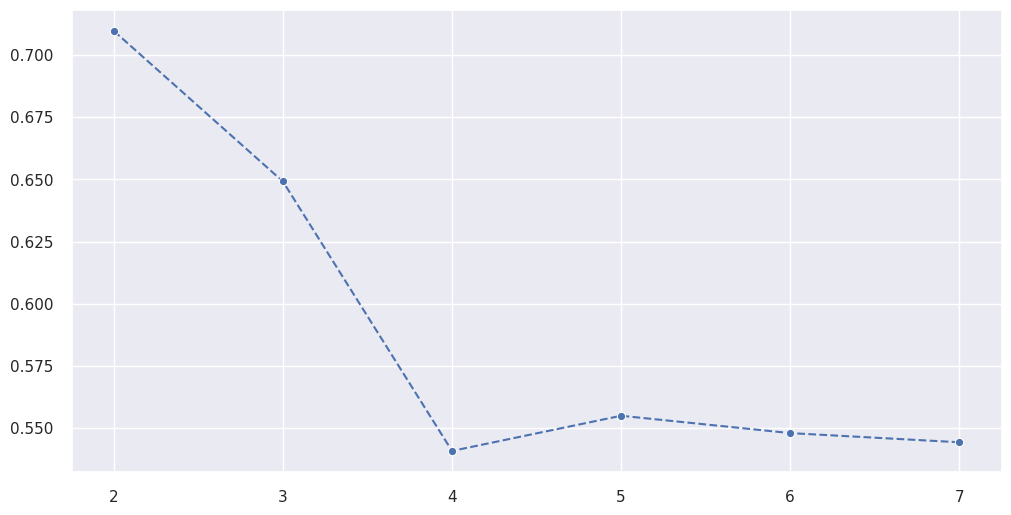

In [187]:
sns.lineplot(x=clusters, y=hc_list, linestyle='--', marker='o', color='b');

## 7.4. DBSCAN

In [188]:
# Raio do Cluster
eps=0.01
# Número de Vizinhos mais próximos
min_samples=20

# Model Definition
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

# Model Training & Predict
db_labels = dbscan_model.fit_predict(X)

# Model Performance
db_sil = silhouette_score(X, db_labels)

print(f"O valor de silhueta para {len(np.unique(db_labels))} {type(dbscan_model).__name__} clusters é de: {db_sil:.4f}")
print(f"Quantidade de Clusters: {len(np.unique(db_labels))}")
print(f"Os labels são: {np.unique(db_labels)}")

O valor de silhueta para 6 DBSCAN clusters é de: 0.2244
Quantidade de Clusters: 6
Os labels são: [-1  0  1  2  3  4]


In [189]:
neighbours = NearestNeighbors(n_neighbors=min_samples)
neighbours.fit(X)
distances, indices = neighbours.kneighbors(X)

Neste exemplo, foi considerado como 20 o número de vizinhos mais próximos. A partir daí, percorremos todo o nosso conjunto de dados, e para todos os pontos, encontramos os 20 vizinhos mais próximos e calculamos a média de suas distâncias. Então, ordenamos suas distâncias de forma ascendente e, com a visualização da distribuição das distâncias, observamos onde há um "cotovelo" na curva, para finalmente decidirmos nosso raio ótimo.

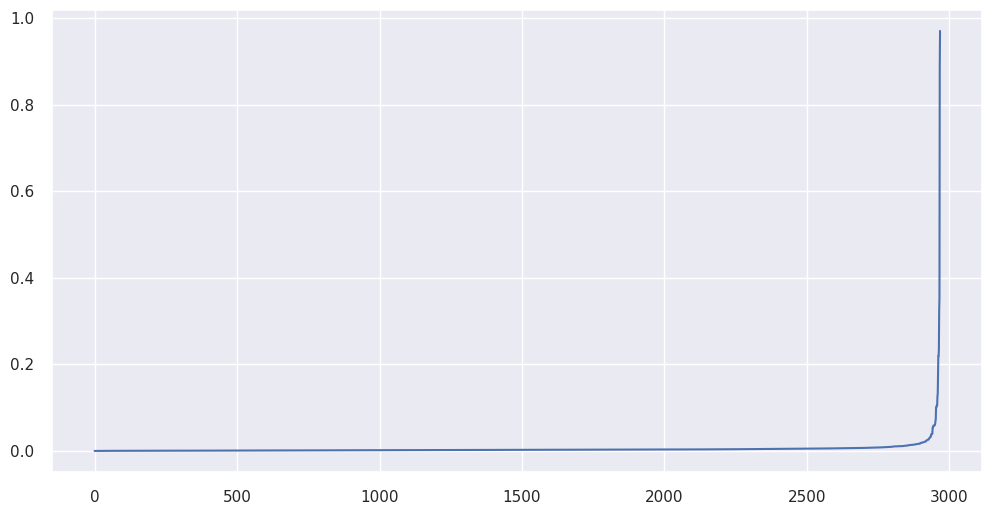

In [190]:
distances_sorted = np.sort(distances, axis=0)
distances_sorted_col = distances_sorted[:, 1]
plt.plot(distances_sorted_col);

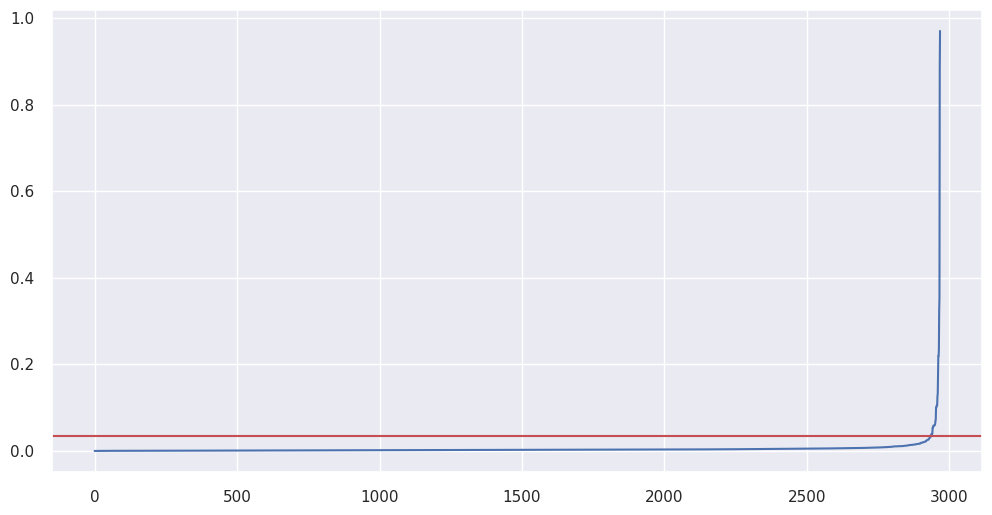

In [195]:
plt.plot(distances_sorted_col)
plt.axhline(0.035, color='r');

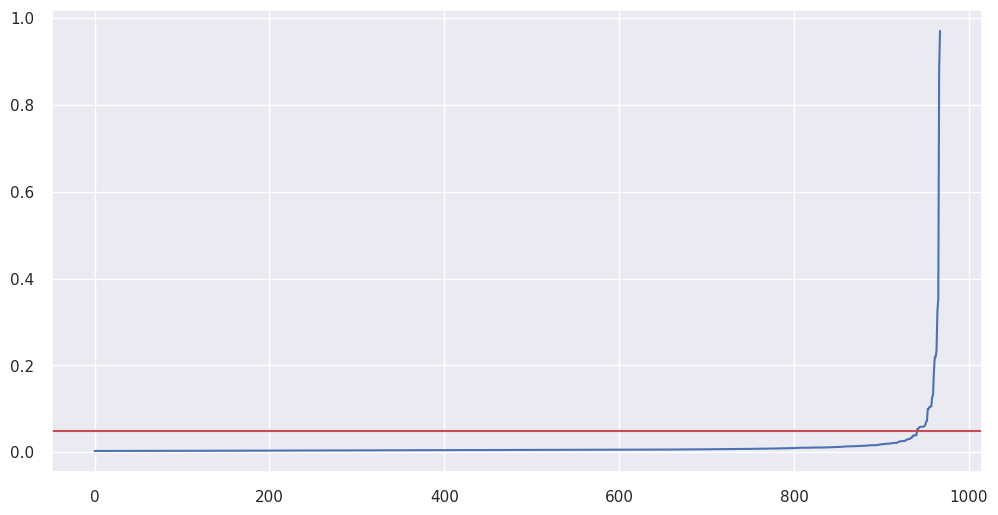

In [198]:
plt.plot(distances_sorted_col[2000:])
plt.axhline(0.05, color='r');

### 7.4.1 Tunando o Silhouette Score com Optuna

In [ ]:
 # Defining an objective function to be optimized
def bayesian_opt_objective(trial):
    eps = trial.suggest_float('eps', 0.01, 0.09, step=0.005)
    min_samples = trial.suggest_int('min_samples', 1, 150, step=1)

    # Defining the model
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    # Training the model and predicting
    labels = dbscan_model.fit_predict(X)
    # Performance
    sil = silhouette_score(X, labels, metric='euclidean')

    return sil 

# maximizing the precision at k
study = optuna.create_study(direction='maximize') 

# optimizing the defined function and setting the number of trials
study.optimize(bayesian_opt_objective, n_trials=30);
trial = study.best_trial

print(f'Best Silhouette Score = {trial.value} with K = {len(set(labels))}')
print(f'Best Hyperparameters = {trial.params}')

## 7.5. HDBSCAN (TBD)

*Loading...next cycle :)*

## 7.6. Resultados

In [102]:
results = pd.DataFrame(
                    {
                    'KMeans': kmeans_list,
                    'GMM':gmm_list,
                    'HC': hc_list,
                    'DBSCAN': [db_sil, 0, 0, 0, 0, 0]
                    }
                    ).T
results.columns = clusters

In [105]:
results.style.highlight_max(color='olive', axis=1)

,2,3,4,5,6,7
KMeans,0.725768,0.598454,0.570207,0.586020,0.558773,0.525752
GMM,-0.046730,0.129126,-0.010430,-0.097739,-0.163756,0.051085
HC,0.709676,0.649179,0.540900,0.555041,0.548071,0.544388
DBSCAN,0.224392,0.000000,0.000000,0.000000,0.000000,0.000000


## 7.7 Análise de Silhueta

K = 2	Silhouette Score: 0.709676319387419
K = 3	Silhouette Score: 0.6491786927683213
K = 4	Silhouette Score: 0.5409000203797215
K = 5	Silhouette Score: 0.5550405355969361
K = 6	Silhouette Score: 0.5480714116702345
K = 7	Silhouette Score: 0.5443877258409187


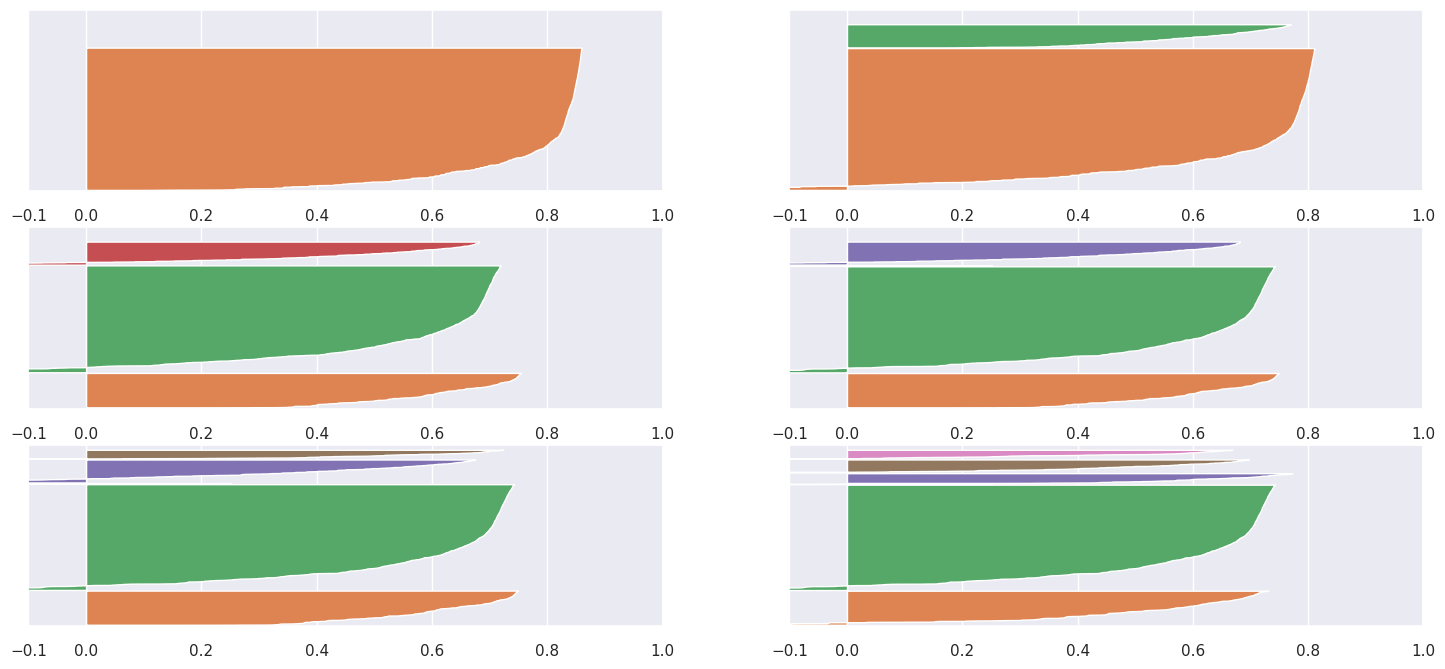

In [204]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(18, 8)

for k in clusters:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
    
    # Model definition
    new_hc_model = hc.linkage(X, method='ward')

    # Model Prediction
    new_hc_labels = hc.fcluster(new_hc_model, k, criterion='maxclust')


    # Model performance
    siso = silhouette_score(X, new_hc_labels, metric='euclidean')
    print(f'K = {k}\tSilhouette Score: {siso}')
    
    samples_sil_values = silhouette_samples(X, labels=new_hc_labels)
    y_lower = 10
    
    for i in range(k):
        
        # Seleciona Clusters
        ith_samples_sil_values = samples_sil_values[new_hc_labels==i]
        
        # Sort Clusters
        ith_samples_sil_values.sort()
        
        # Size Clusters
        size_cluster_i = ith_samples_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap_cluster = cm.get_cmap('Spectral')
        color_cluster = cmap_cluster(i/k)
        
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_sil_values)
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1.0])

### 7.7.1 Within-Cluster Sum of Square (WSS for KMeans only)

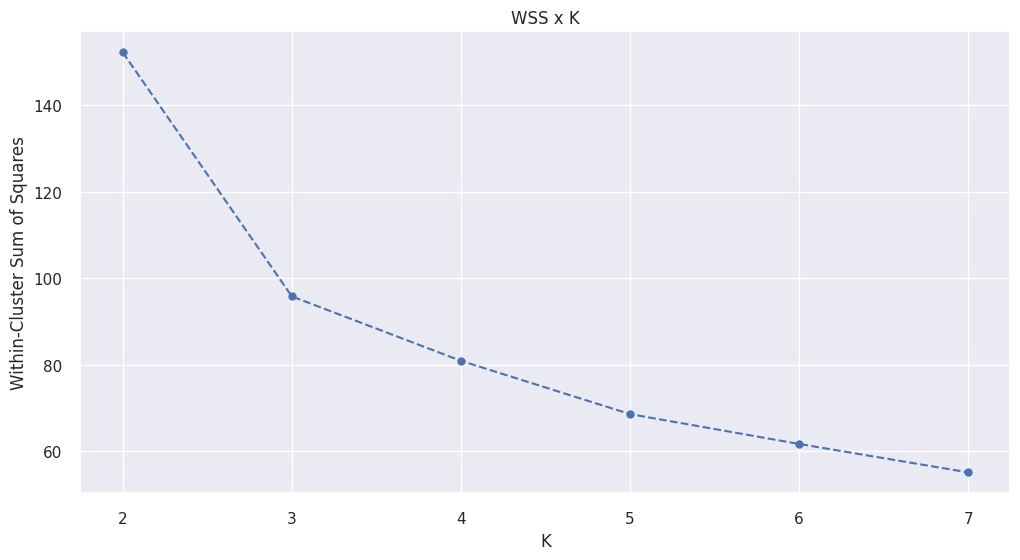

In [237]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=CFG.seed)
    
    # model training
    kmeans.fit(X)
    
    # validation    
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method - Método Cotovelo
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('WSS x K');

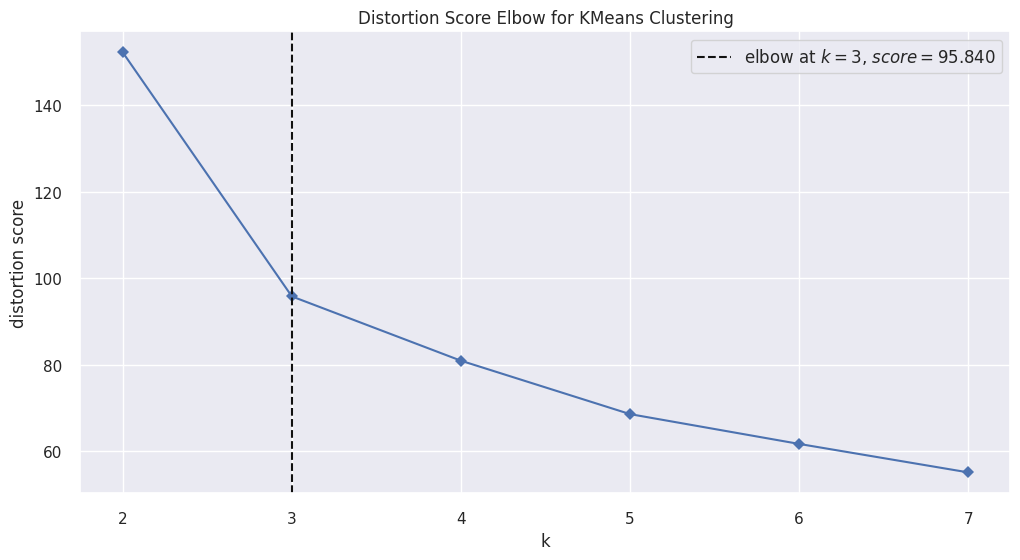

In [231]:
kmeans = KElbowVisualizer(KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

### 7.7.2 Silhouette Score (for KMeans only)

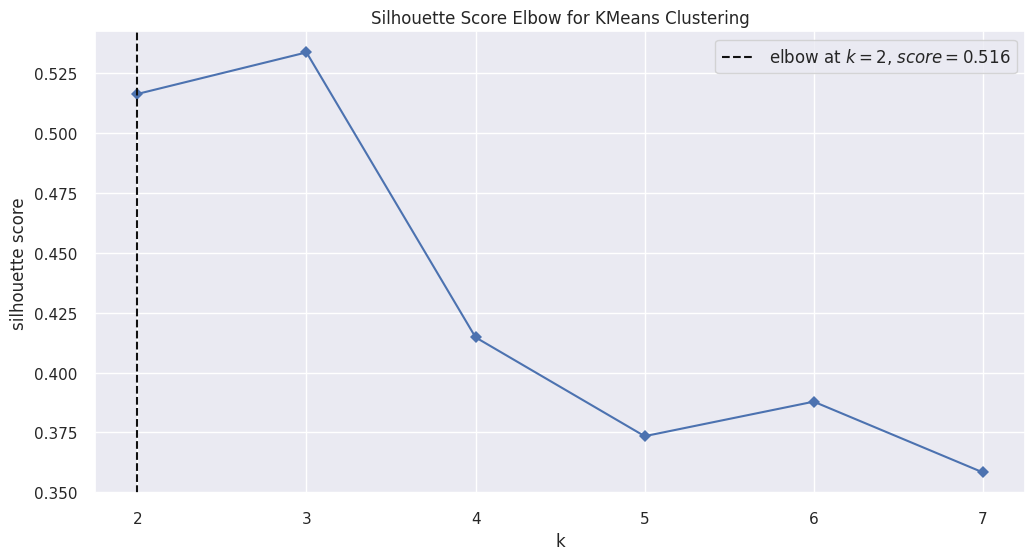

In [106]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

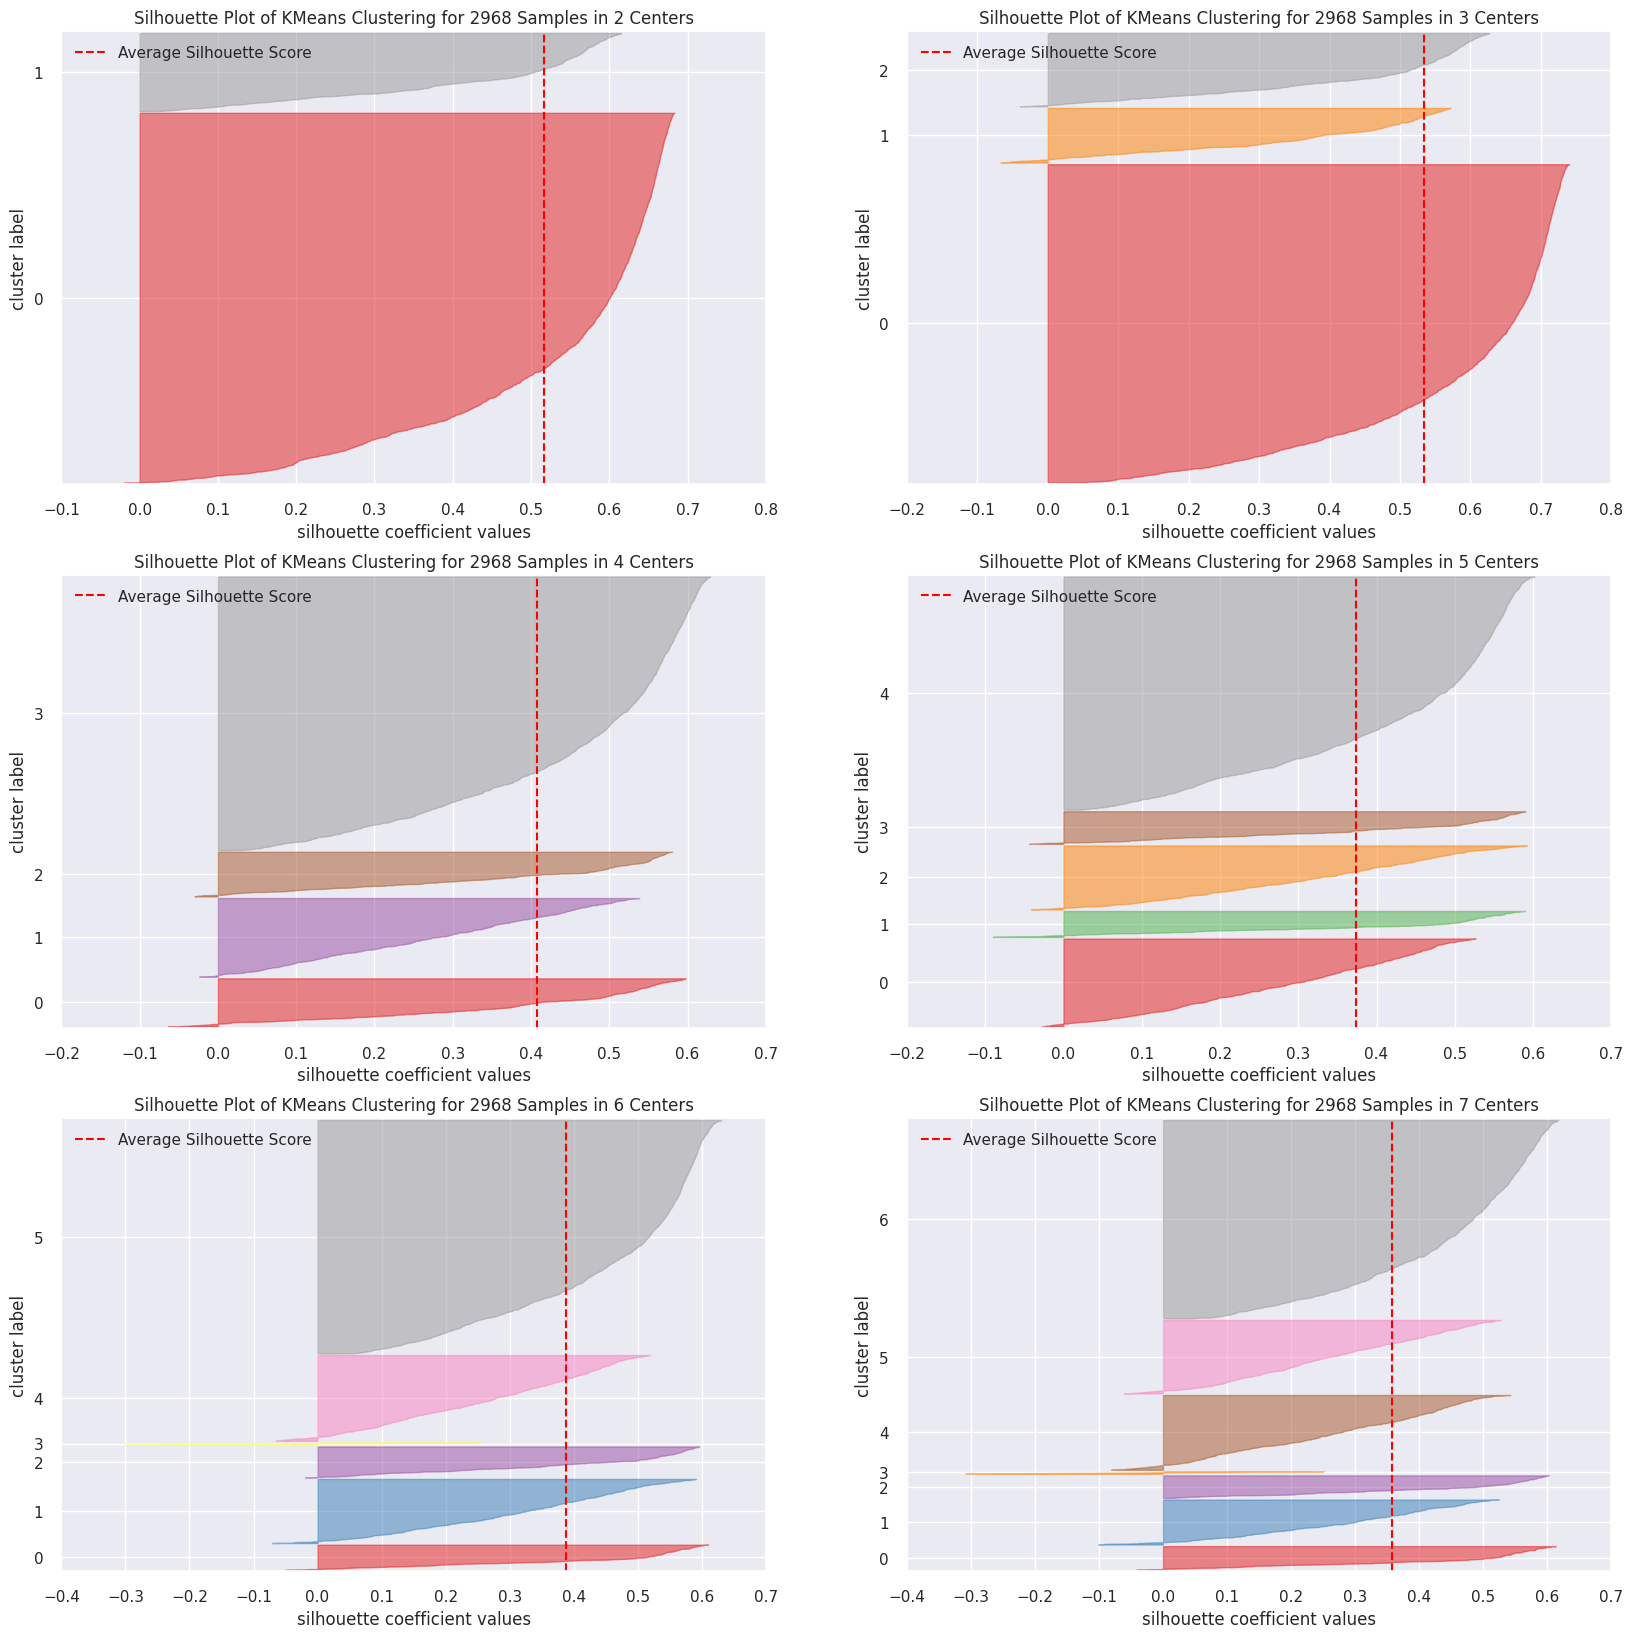

In [233]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

for k in clusters:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=CFG.seed)
    q, mod = divmod(k, 2)
    viz = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    viz.fit(X)
    viz.finalize()

# 8.0 Model Training

## 8.1. Models Configuration

In [ ]:
# k = 10
# model = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

In [315]:
# model definition
k = 9
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.predict(X) # ou kmeans.labels_

## 8.2. Cluster Validation

In [316]:
## WSS 
print(f'WSS value: {kmeans.inertia_}')

## SS
print(f'SS value: {silhouette_score(X, labels, metric="euclidean")}')

WSS value: 26884.35546875
SS value: 0.5864775776863098


# 9.0 Cluster Analysis

In [313]:
df9 = X.copy()
df9['cluster'] = labels

In [317]:
# # df9 = df6.copy()
# df9 = df5.copy() # Pegando um dataframe ANTES do redimensionamento!
# df9['cluster'] = labels
# df9.head()

## 9.1. Visualization Inspection

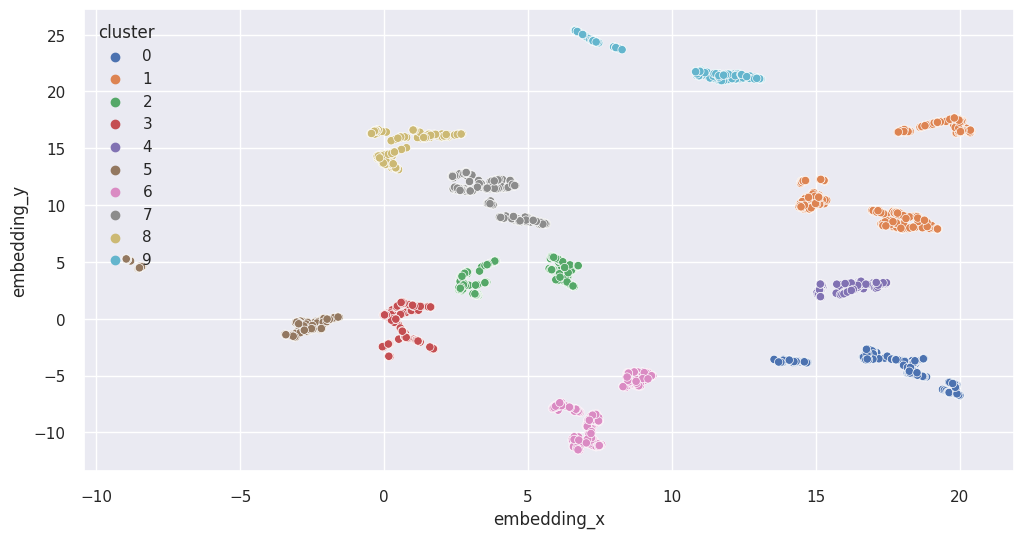

In [318]:
sns.scatterplot(data=df9, hue='cluster', x='embedding_x', y='embedding_y', palette='deep');

In [276]:
# viz = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# viz.fit(X)
# viz.finalize()

## 9.2. Two-Dimensional Plot

In [277]:
# df_viz = df9.drop(columns='customer_id', axis=1)
# sns.pairplot(df_viz, hue='cluster');

## 9.3. UMAP

In [214]:
X.head()

,monetary,recency,frequency,qtde_products,qtdade_itens_retornados
0,0.01929,0.99732,1.00000,0.03777,0.00049
1,0.01156,0.15013,0.00134,0.02169,0.00043
2,0.02400,0.00536,0.00205,0.02948,0.00062
3,0.00337,0.25469,0.00073,0.00345,0.00000
4,0.00312,0.89276,0.00398,0.00026,0.00027


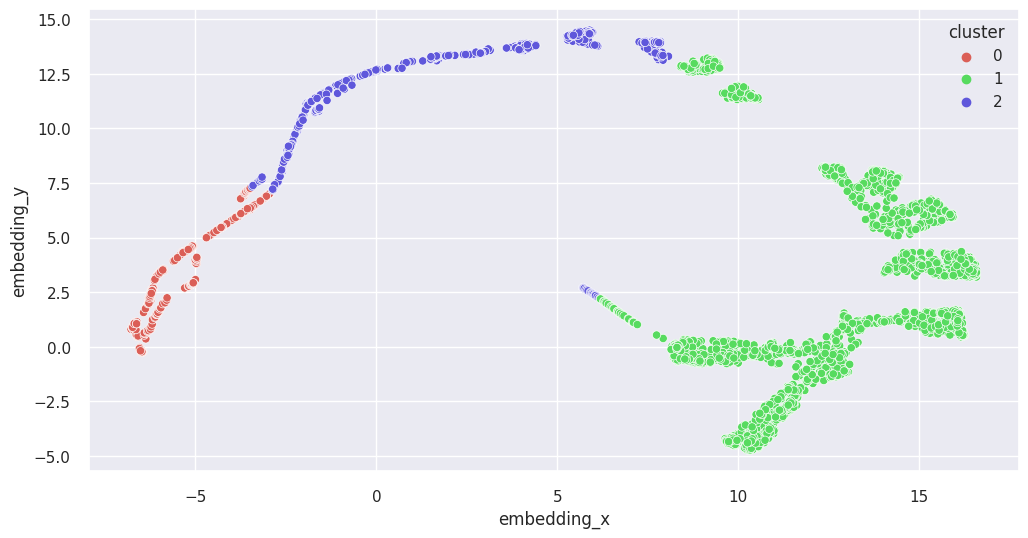

In [210]:
reducer = umap.UMAP(n_neighbors=90, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_umap_viz = df9.drop(columns='customer_id', axis=1)
df_umap_viz['embedding_x'] = embedding[:, 0]
df_umap_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=df_umap_viz['cluster'].nunique()),
               data=df_umap_viz);

In [76]:
## fig = px.scatter_3d(df9, x='recency', y='frequency', z='monetary', color='cluster')
# fig.show()

## 9.4. Cluster Profile

In [273]:
df9.head()

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtdade_itens_retornados,avg_basket_size,avg_unique_basket_size,cluster
0,17850,"5,391.21",372.00,34.00,"1,733.00",297.00,18.15,35.50,17.00,40.00,50.97,0.62,0
1,13047,"3,232.59",56.00,9.00,"1,390.00",171.00,18.90,27.25,0.03,35.00,154.44,11.67,1
2,12583,"6,705.38",2.00,15.00,"5,028.00",232.00,28.90,23.19,0.04,50.00,335.20,7.60,1
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,4.80,2
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33,0


In [274]:
pd.options.display.float_format = '{:,.2f}'.format

# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg Monetary
df_avg_monetary = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, on='cluster')

# Avg recency days
df_avg_recency = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster')

# Avg Frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster')

# Avg Qtde Products
df_avg_frequency = df9[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster')

# Avg Qtde Returns
df_avg_frequency = df9[['qtdade_itens_retornados', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster')

# # Avg Ticket
# df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_ticket, on='cluster')

df_cluster

,cluster,customer_id,perc_customer,monetary,recency,frequency,qtde_products,qtdade_itens_retornados
0,0,333,11.22,860.76,246.25,0.40,37.67,47.46
1,1,1983,66.81,"3,574.82",21.16,0.06,156.89,81.92
2,2,652,21.97,"1,204.97",102.59,0.12,61.99,9.66


**Exemplo de leitura da tabela:**

In [275]:
print(f'Após a aplicação do modelo, constatamos que há a presença de {df_cluster.cluster.nunique()} clusters.\n \
      \n- Cluster {df_cluster.cluster.unique()[0]}: composto por {df_cluster.customer_id[0]} pessoas, representando {df_cluster.perc_customer[0]:.2f}% de nossa base, gastaram {round(df_cluster.monetary[0], 2)} dólares em média, com uma recência média de {round(df_cluster.recency[0])} dias, comprando em média {round(df_cluster.qtde_products[0])} produtos e retornando {round(df_cluster.qtdade_itens_retornados[0])}. \
      \n- Cluster {df_cluster.cluster.unique()[1]}: composto por {df_cluster.customer_id[1]} pessoas, representando {df_cluster.perc_customer[1]:.2f}% de nossa base, gastaram {round(df_cluster.monetary[1], 2)} dólares em média, com uma recência média de {round(df_cluster.recency[1])} dias, comprando em média {round(df_cluster.qtde_products[1])} produtos e retornando {round(df_cluster.qtdade_itens_retornados[1])}. \
      \n- Cluster {df_cluster.cluster.unique()[2]}: composto por {df_cluster.customer_id[2]} pessoas, representando {df_cluster.perc_customer[2]:.2f}% de nossa base, gastaram {round(df_cluster.monetary[2], 2)} dólares em média, com uma recência média de {round(df_cluster.recency[2])} dias, comprando em média {round(df_cluster.qtde_products[2])} produtos e retornando {round(df_cluster.qtdade_itens_retornados[2])}. \
      ')

Após a aplicação do modelo, constatamos que há a presença de 3 clusters.
       
- Cluster 0: composto por 333 pessoas, representando 11.22% de nossa base, gastaram 860.76 dólares em média, com uma recência média de 246 dias, comprando em média 38 produtos e retornando 47.       
- Cluster 1: composto por 1983 pessoas, representando 66.81% de nossa base, gastaram 3574.82 dólares em média, com uma recência média de 21 dias, comprando em média 157 produtos e retornando 82.       
- Cluster 2: composto por 652 pessoas, representando 21.97% de nossa base, gastaram 1204.97 dólares em média, com uma recência média de 103 dias, comprando em média 62 produtos e retornando 10.       


### Cluster 01:  (Premium - Candidato à Insider)
    - Número de customers: 6 (0,14% dos clientes)
    - Recência média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: U$ 182.182,00 
    
### Cluster 02: (VIPs)
    - Número de customers: 31 (0,71% dos clientes)
    - Recência média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: U$ 40.543,52 
    
### Cluster 03: (Ocasionais)
    - Número de customers: 4.335 (99% dos clientes)
    - Recência média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: U$ 1.372,57 


# 10.0 Deployment

# 11.0 SandBox

## 11.1. Original Dataset

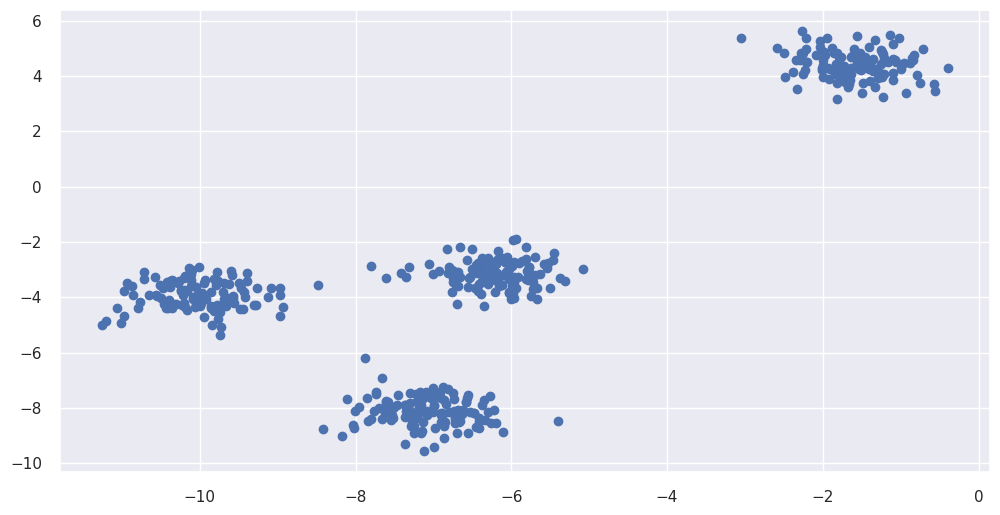

In [49]:
from sklearn.datasets import make_blobs #cria pontos no espaço

X, y = make_blobs(n_samples=500, n_features=2, 
                  centers=4,
                  cluster_std=0.5,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=CFG.seed)
# plot dataset
plt.scatter(X[:, 0], X[:, 1])

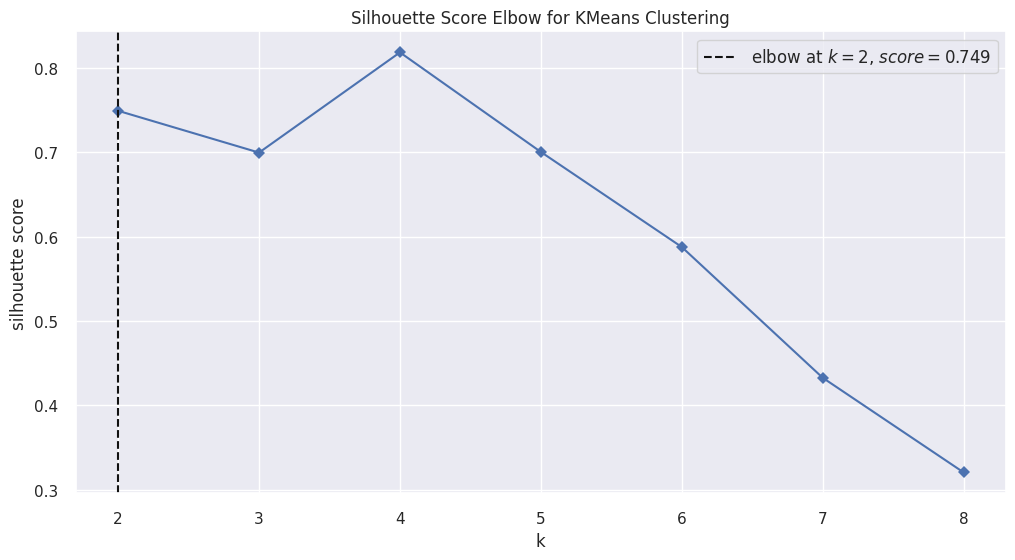

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [50]:
# modeling
clusters = list(range(2, 9))
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

## 11.2. Silhouette Analysis

IndexError: index 2 is out of bounds for axis 0 with size 2

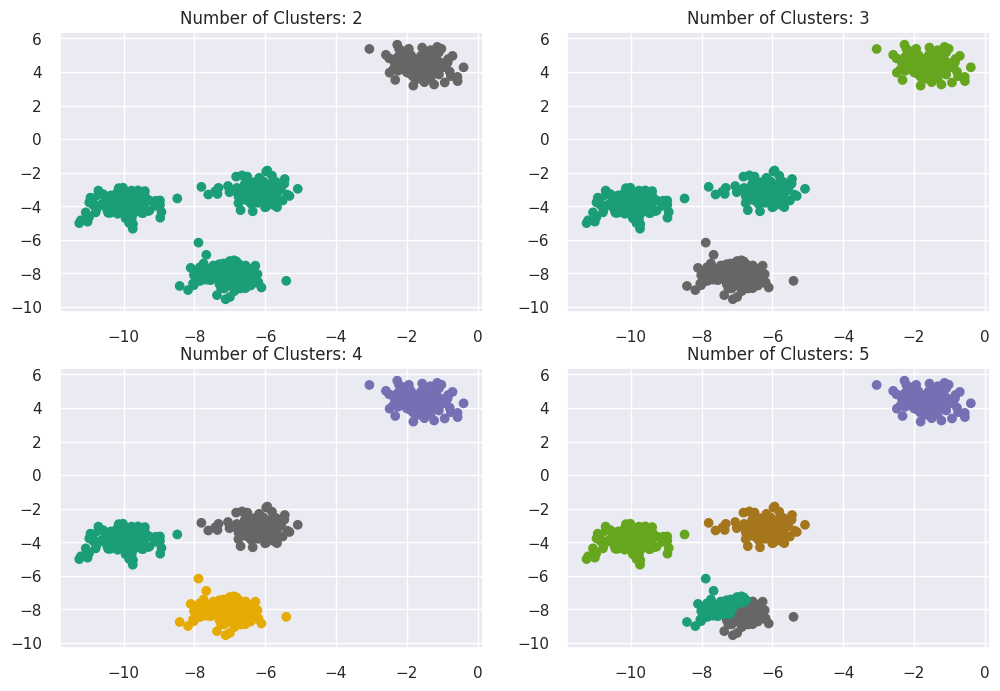

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    kmeans.fit(X)
    
    q, mod = divmod(i, 2)
    ax[q-1, mod].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=plt.cm.Dark2)
    ax[q-1, mod].set_title('Number of Clusters: {}'.format(i))
plt.show()

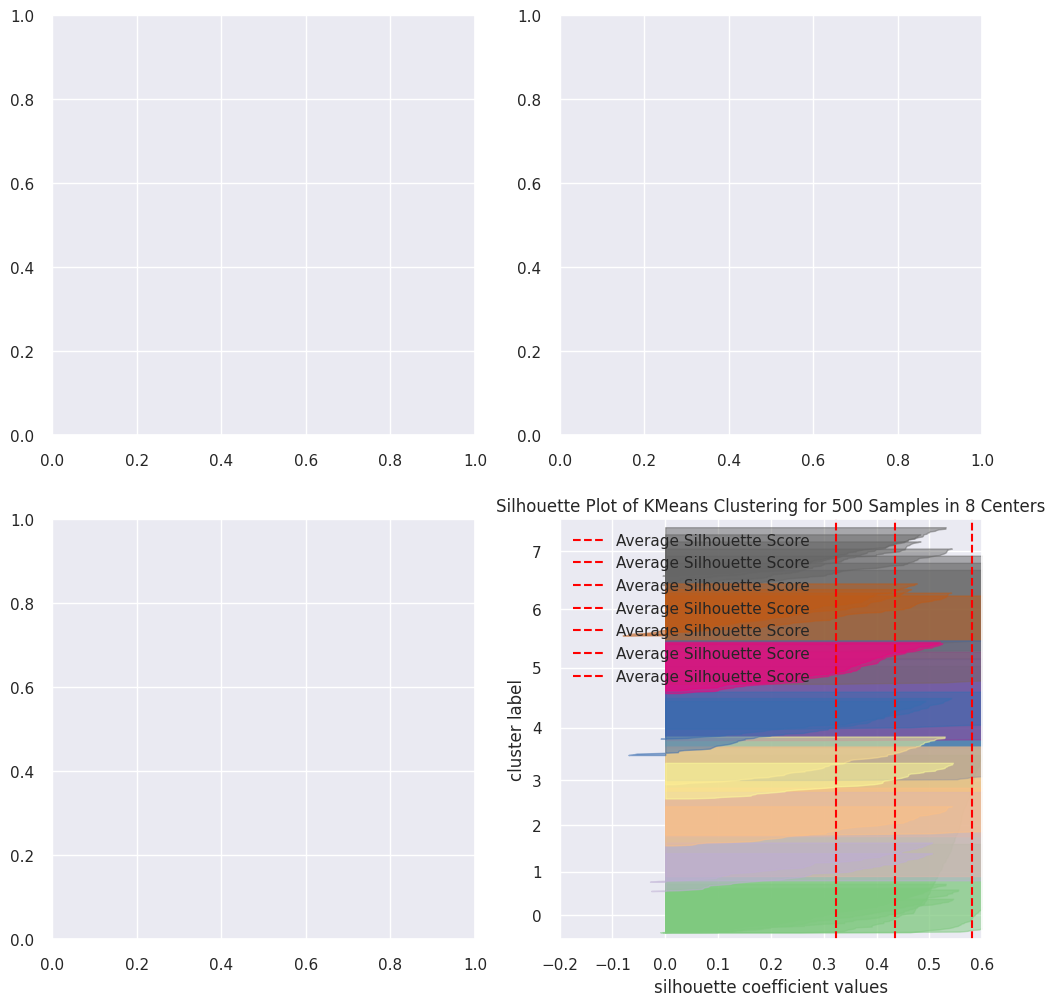

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(kmeans, colors='Accent')
    visualizer.fit(X)
    visualizer.finalize()